In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [4]:
pwd

'C:\\Users\\DELL\\Documents\\ALABS\\Python_ML_Project\\CS4\\src'

In [5]:
online_sales=pd.read_csv("..//input_data/Online_Sales.csv")
discount_coupon =pd.read_csv("..//input_data/Discount_Coupon.csv")
tax_amount = pd.read_excel("..//input_data/Tax_amount.xlsx")
customer_data = pd.read_excel("..//input_data/CustomersData.xlsx")
marketing_spend = pd.read_csv("..//input_data/Marketing_Spend.csv")

In [6]:
# we will find missing values and check the data types for all the datasets

In [7]:
online_sales.isna().sum()

CustomerID             0
Transaction_ID         0
Transaction_Date       0
Product_SKU            0
Product_Description    0
Product_Category       0
Quantity               0
Avg_Price              0
Delivery_Charges       0
Coupon_Status          0
dtype: int64

In [8]:
discount_coupon.isna().sum()

Month                0
Product_Category     0
Coupon_Code          0
Discount_pct         0
dtype: int64

In [9]:
customer_data.isna().sum()

CustomerID       0
Gender           0
Location         0
Tenure_Months    0
dtype: int64

In [10]:
marketing_spend.isna().sum()

Date             0
Offline_Spend    0
Online_Spend     0
dtype: int64

In [11]:
tax_amount.isna().sum()

Product_Category    0
GST                 0
dtype: int64

In [12]:
online_sales.dtypes # need to convert transaction_date to date time

CustomerID               int64
Transaction_ID           int64
Transaction_Date         int64
Product_SKU             object
Product_Description     object
Product_Category        object
Quantity                 int64
Avg_Price              float64
Delivery_Charges       float64
Coupon_Status           object
dtype: object

In [13]:
online_sales.Transaction_Date=pd.to_datetime(online_sales.Transaction_Date,format="%Y%m%d")

In [14]:
# we will add 3 columns in the online sales- transaction day, transaction month, abbreviated month name and transaction week for analysis

In [15]:
online_sales["transaction_month"]=online_sales.Transaction_Date.dt.month

In [16]:
online_sales["transaction_day"]=online_sales.Transaction_Date.dt.day

In [17]:
online_sales.Transaction_Date

0       2019-01-01
1       2019-01-01
2       2019-01-01
3       2019-01-01
4       2019-01-01
           ...    
52919   2019-12-31
52920   2019-12-31
52921   2019-12-31
52922   2019-12-31
52923   2019-12-31
Name: Transaction_Date, Length: 52924, dtype: datetime64[ns]

In [18]:
online_sales["week_no"]=online_sales.Transaction_Date.dt.isocalendar().week

In [19]:
online_sales["abbrevaited_month_name"]=online_sales.Transaction_Date.dt.strftime("%b")

In [20]:
online_sales.head(2)

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,transaction_month,transaction_day,week_no,abbrevaited_month_name
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,1,1,Jan
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,1,1,1,Jan


In [21]:
list1=['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct']

In [22]:
discount_coupon.columns = list1

In [23]:
discount_coupon.columns

Index(['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct'], dtype='object')

In [24]:
# concating month and product category in the discount_table

In [25]:
discount_coupon["primary_key"]=discount_coupon.Month+discount_coupon.Product_Category

In [26]:
online_sales["key"]=online_sales.abbrevaited_month_name+online_sales.Product_Category

In [27]:
tax_amount.head()

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [28]:
# we will merge online sales and product discount coupon first using the key columns which we created usimg left join

In [29]:
pd.merge?

In [30]:
req1=pd.merge(left=online_sales,right=discount_coupon,how="left",left_on="key",right_on="primary_key")

In [31]:
online_sales.shape

(52924, 15)

In [32]:
req1.shape

(52924, 20)

In [33]:
# we will merge the above df with GST lab from tax_amount dataset using left join and product_category as the key

In [34]:
req1.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'Product_Category_x', 'Quantity', 'Avg_Price',
       'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Product_Category_y', 'Coupon_Code', 'Discount_pct', 'primary_key'],
      dtype='object')

In [35]:
# we will drop column product category y 

In [36]:
req1.drop(columns=["Product_Category_y"],inplace=True)

In [37]:
req1.rename(columns={"Product_Category_x":"product_categgory_sales_table"},inplace=True)

In [38]:
req2=pd.merge(left=req1,right=tax_amount,how="left",left_on="product_categgory_sales_table",right_on="Product_Category")

In [39]:
req2.shape

(52924, 21)

## Analysis of Data

##### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level
 Invoice Value =(( Quantity*Avg_price)*(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [40]:
from numpy import where as IF

In [41]:
req2["updated_dis_per"]=IF(req2.Coupon_Status=="Used",req2.Discount_pct,0)

In [42]:
req2.GST

0        0.10
1        0.10
2        0.10
3        0.18
4        0.18
         ... 
52919    0.10
52920    0.18
52921    0.10
52922    0.10
52923    0.10
Name: GST, Length: 52924, dtype: float64

In [43]:
req2["invoice_value"]=((req2.Quantity*req2.Avg_Price)*(1-(0.01*req2.updated_dis_per))*(1+req2.GST))+req2.Delivery_Charges

## 2. Perform Detailed exploratory analysis

a Understanding how many customers acquired every month

b Understand the retention of customers on month on month basis

c How the revenues from existing/new customers on month on month basis

In [44]:
t_month_cust_dict={}
for m in range(1,13):
    t_month_cust_dict[m]=set(req2[req2.transaction_month==m].CustomerID)

In [45]:
t_month_cust_dict

{1: {12431,
  12433,
  12471,
  12472,
  12583,
  12662,
  12686,
  12738,
  12748,
  12791,
  12838,
  12855,
  12868,
  12915,
  12921,
  12947,
  12967,
  12971,
  13011,
  13047,
  13065,
  13090,
  13093,
  13108,
  13117,
  13138,
  13145,
  13255,
  13295,
  13305,
  13370,
  13402,
  13408,
  13418,
  13448,
  13468,
  13491,
  13576,
  13694,
  13705,
  13715,
  13747,
  13748,
  13758,
  13767,
  13777,
  13798,
  13941,
  13958,
  14001,
  14031,
  14045,
  14047,
  14060,
  14078,
  14092,
  14135,
  14142,
  14156,
  14180,
  14213,
  14236,
  14237,
  14264,
  14307,
  14388,
  14390,
  14395,
  14443,
  14449,
  14466,
  14491,
  14496,
  14527,
  14573,
  14576,
  14594,
  14606,
  14625,
  14679,
  14688,
  14696,
  14729,
  14741,
  14766,
  14775,
  14829,
  14849,
  14865,
  14901,
  14911,
  15012,
  15061,
  15070,
  15093,
  15100,
  15107,
  15111,
  15165,
  15235,
  15240,
  15260,
  15291,
  15299,
  15311,
  15350,
  15363,
  15384,
  15485,
  15513,
  15525

In [46]:
def get_customer_status(data_frame):
    c_id=data_frame.CustomerID
    transaction_month=data_frame.transaction_month
    for m in range(1,transaction_month):
        if c_id in t_month_cust_dict[m]:
            return True
    return False

In [47]:
req2["new_old_cust"]=req2.apply(get_customer_status,axis=1)

In [48]:
req2["new_old_cust"]=IF(req2.new_old_cust==True,"repeat","new")

In [49]:
req2.new_old_cust.value_counts()

new_old_cust
new       32033
repeat    20891
Name: count, dtype: int64

In [50]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust'],
      dtype='object')

In [51]:
q_2=req2.groupby(["transaction_month","new_old_cust"]).agg({'CustomerID':'nunique','invoice_value':'sum'}).reset_index()

In [52]:
q_2

,transaction_month,new_old_cust,CustomerID,invoice_value
0,1,new,215,493209.34775
1,2,new,96,327858.55568
2,2,repeat,13,46524.59322
3,3,new,177,344627.75096
4,3,repeat,31,66994.05468
5,4,new,163,279687.47152
6,4,repeat,61,195496.61090
7,5,new,112,232618.80248
8,5,repeat,88,131758.36628
9,6,new,137,216918.94528


In [53]:
q_2.to_csv("analysis.csv")

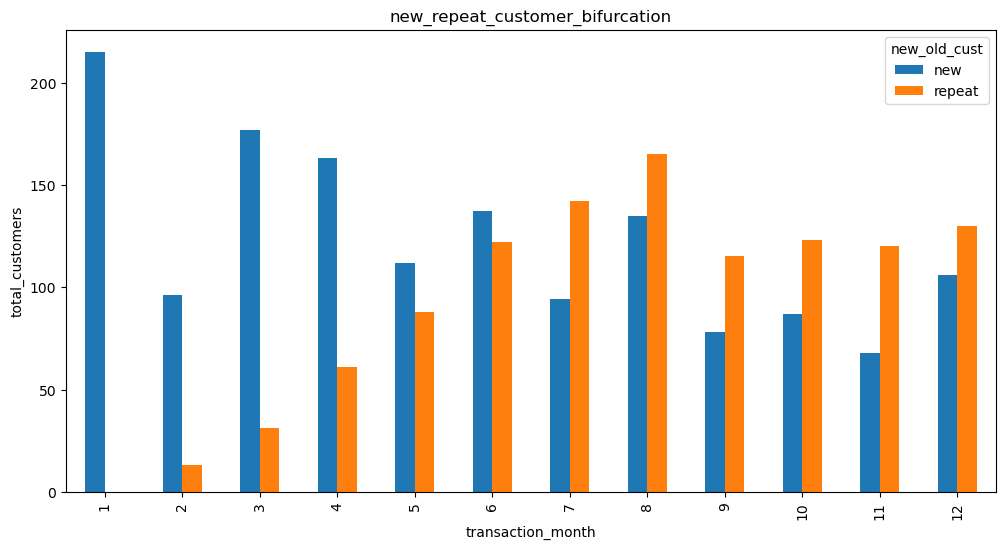

In [54]:
q_2.pivot_table(index="transaction_month",columns="new_old_cust",values="CustomerID").plot(kind="bar",figsize=(12,6))
plt.ylabel("total_customers")
plt.title("new_repeat_customer_bifurcation")
plt.show()

###### the repeat customers have gone down after month 8 , the new customer acquisition also went down drastcailly after month 8 and them improved in monthn 10 and 12

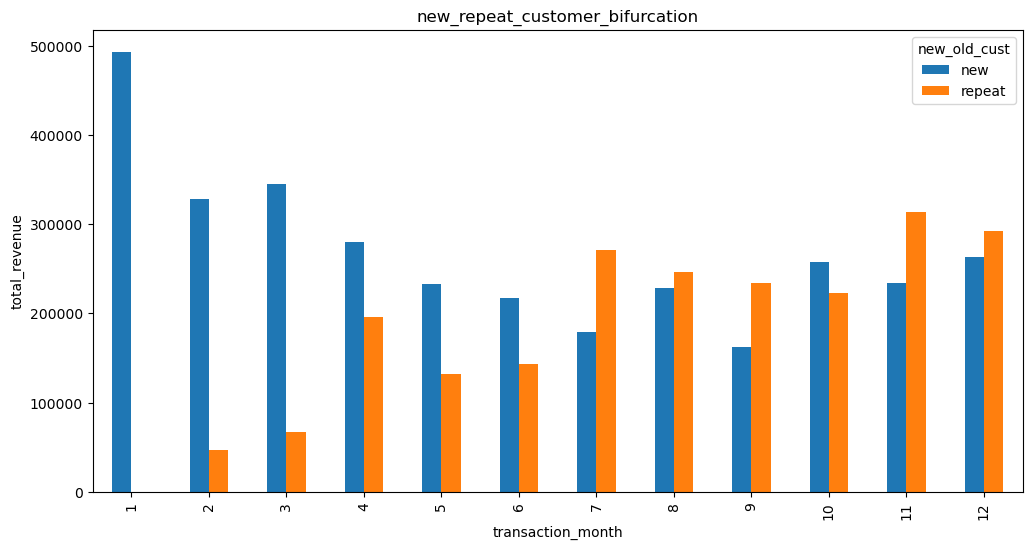

In [55]:
q_2.pivot_table(index="transaction_month",columns="new_old_cust",values="invoice_value").plot(kind="bar",figsize=(12,6))
plt.ylabel("total_revenue")
plt.title("new_repeat_customer_bifurcation")
plt.show()

the revenue from new customers was declining till month 7 and then improved from month 8
the revenue from repeat customers declined from month 7 and then improved in month 11

d. How the discounts playing role in the revenues?

#finding how discouts play the role in invoice value-
a. we will look at the average invoice value for each of the discount percentage
b. we will look at the overall revenue generated against each of the discount percenatge

In [56]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust'],
      dtype='object')

<Axes: xlabel='Discount_pct'>

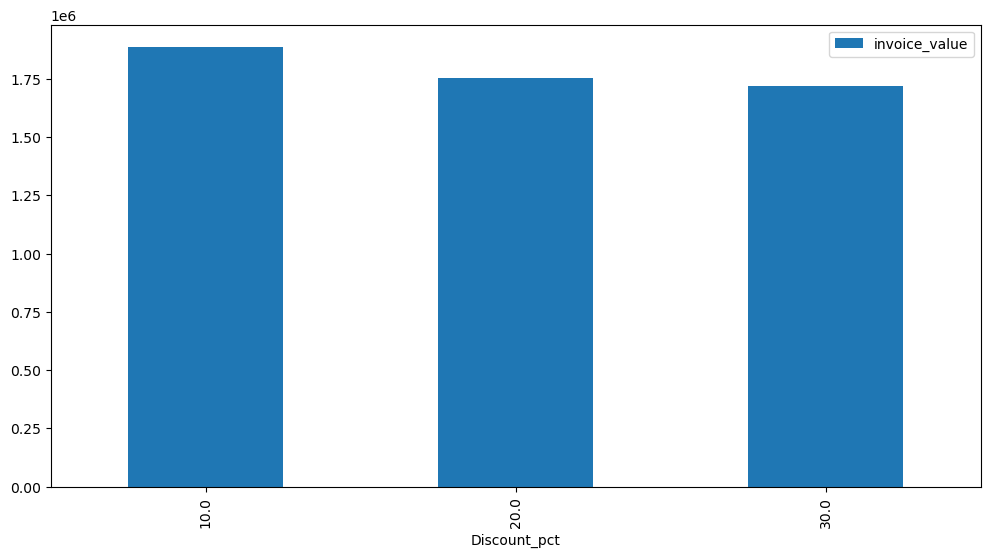

In [57]:
req2.groupby(["Discount_pct"]).agg({"invoice_value":"sum"}).plot(kind="bar",figsize=(12,6))

In [58]:
q_2_d=req2.groupby(["Discount_pct"]).agg({"invoice_value":"sum","Transaction_ID":"nunique"}).reset_index()

In [59]:
q_2_d["average_transaction_value"]=q_2_d.invoice_value/q_2_d.Transaction_ID

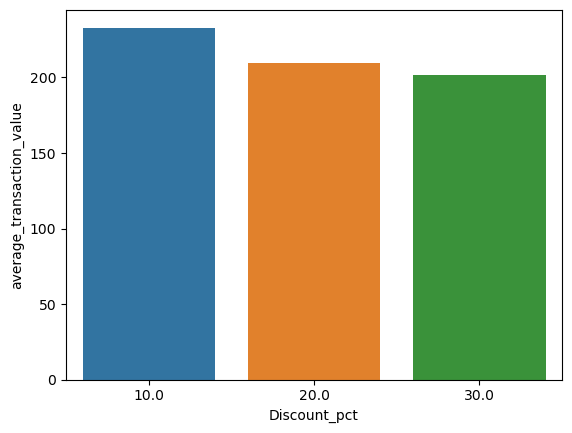

In [60]:
sns.barplot(x=q_2_d.Discount_pct,y=q_2_d.average_transaction_value)
plt.show()

In [61]:
#The average transaction value is higher for 10% discount and overall revenue also, hence discount is not the main driver regarding hig revenue

d. Analyse KPI’s like Revenue, number of orders, average order value, number of 
customers (existing/new), quantity, by category, by month, by week, by day etc…

In [62]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust'],
      dtype='object')

In [63]:
#nummber of customers by month has already been done in earlier question, we will analyze by day and week here

In [64]:
t_week_cust_dict={}
for w in range(1,53):
    t_week_cust_dict[w]=set(req2[req2.week_no==w].CustomerID)

In [65]:
def get_customer_status_week(data_frame):
    c_id=data_frame.CustomerID
    transaction_week=data_frame.week_no
    for w in range(1,transaction_week):
        if c_id in t_week_cust_dict[w]:
            return True
    return False

In [66]:
req2["new_repeat_week"]=req2.apply(get_customer_status_week,axis=1)

In [67]:
req2["mew_repeat_week"]=IF(req2.new_repeat_week==True,"repeat","new")

In [68]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust', 'new_repeat_week',
       'mew_repeat_week'],
      dtype='object')

In [69]:
req2.drop(columns=["new_repeat_week"],inplace=True)

In [70]:
req2.rename(columns={"mew_repeat_week":"new_repeat_week"},inplace=True)

In [71]:
req2.transaction_day.value_counts()

transaction_day
13    2066
27    2062
18    1985
6     1878
11    1864
19    1859
7     1828
14    1828
17    1807
21    1781
12    1747
16    1740
4     1740
5     1736
3     1732
22    1731
1     1723
24    1682
20    1671
26    1661
28    1661
30    1619
10    1614
9     1610
2     1606
15    1604
8     1531
25    1525
23    1506
29    1277
31    1250
Name: count, dtype: int64

In [72]:
t_day_cust_dict={}
for d in range(1,32):
    t_day_cust_dict[d]=set(req2[req2.week_no==d].CustomerID)

def get_customer_status_day(data_frame):
    c_id=data_frame.CustomerID
    transaction_day=data_frame.transaction_day
    for d in range(1,transaction_day):
        if c_id in t_day_cust_dict[d]:
            return True
    return False

In [73]:
req2["new_repeat_day"]=req2.apply(get_customer_status_day,axis=1)

In [74]:
req2["new_repeat_day"]=IF(req2.new_repeat_day==True,"repeat","new")

In [75]:
df=req2.groupby(["week_no","new_repeat_week"]).agg({'CustomerID':'nunique','invoice_value':'sum'}).reset_index()

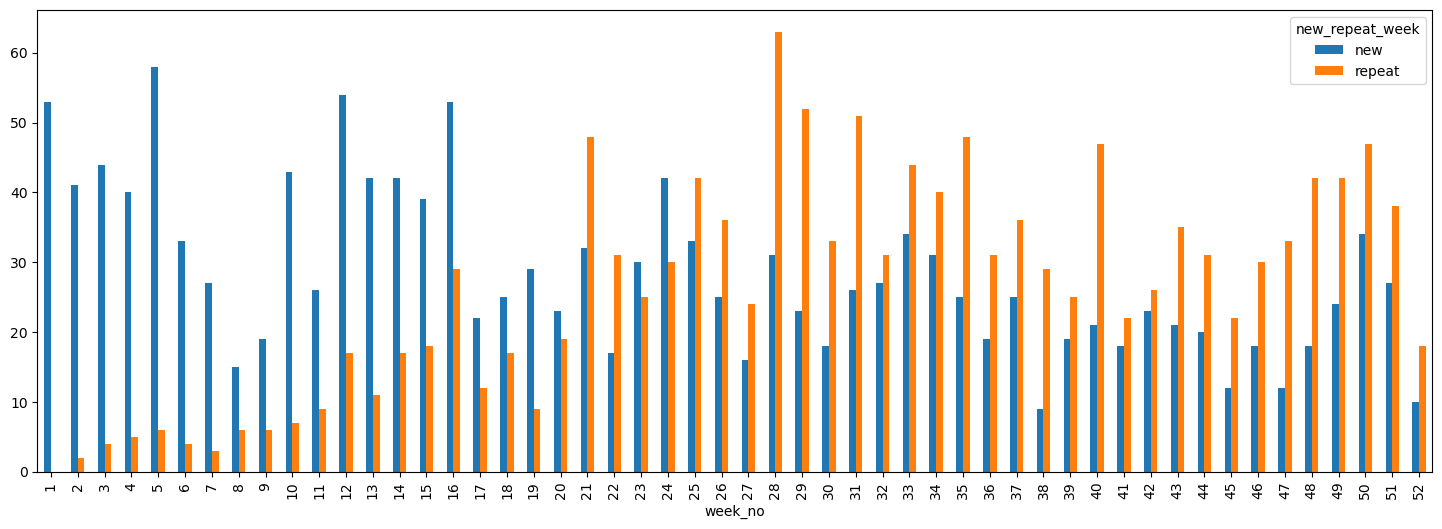

In [76]:
df.pivot_table(index="week_no",columns="new_repeat_week",values="CustomerID").plot(kind="bar",figsize=(18,6))
plt.show()


# repeat customers have gone very high from week no 27 and then came down after that
# new customers are highest in the early part of year but tafter declining till week 27 they have gone up


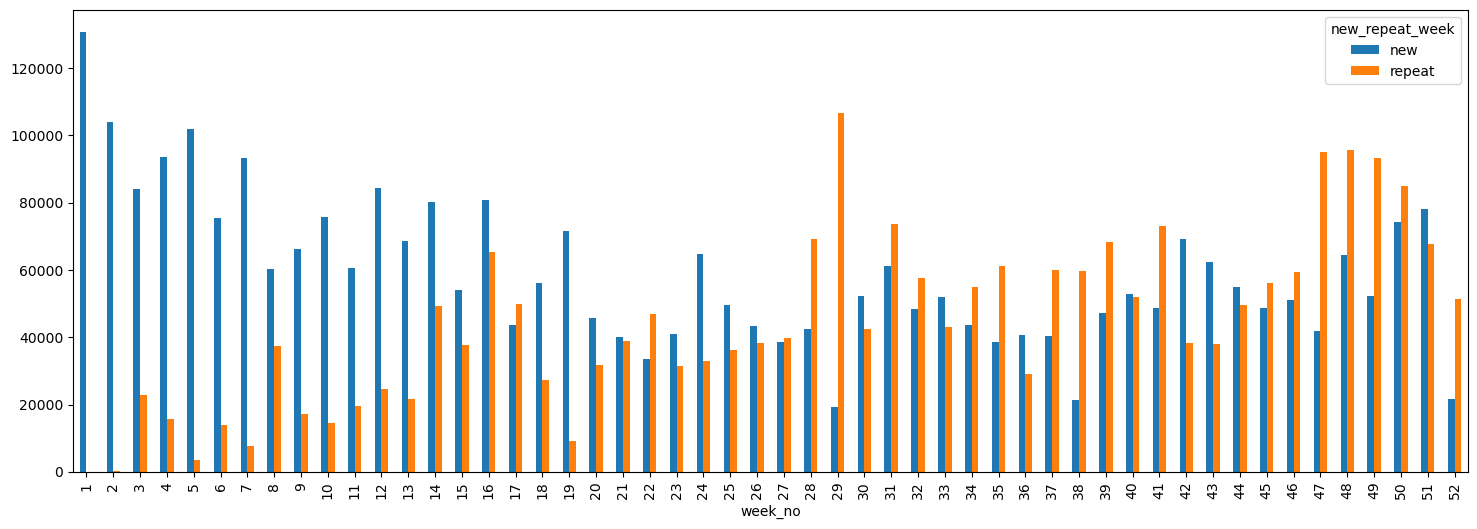

In [77]:
df.pivot_table(index="week_no",columns="new_repeat_week",values="invoice_value").plot(kind="bar",figsize=(18,6))
plt.show()

In [78]:
df.pivot_table(index="week_no",columns="new_repeat_week",values="invoice_value").describe() 

new_repeat_week,new,repeat
count,52.000000,51.000000
mean,59047.152653,45392.883506
std,22044.331014,25066.798666
min,19321.289710,193.152880
25%,43542.309085,28177.417275
50%,53495.693790,42564.974970
75%,72238.631390,59933.971810
max,130813.917770,106721.920820


In [79]:
# the average value per customer is more for new customer , total revenue is also more for new customer orders

In [80]:
df.pivot_table(index="week_no",columns="new_repeat_week",values="CustomerID").describe()

new_repeat_week,new,repeat
count,52.000000,51.000000
mean,28.230769,26.529412
std,11.796668,15.491098
min,9.000000,2.000000
25%,19.000000,14.500000
50%,25.500000,29.000000
75%,34.000000,37.000000
max,58.000000,63.000000


In [81]:
# analyzing revenue by  by category, by month, by week, by day

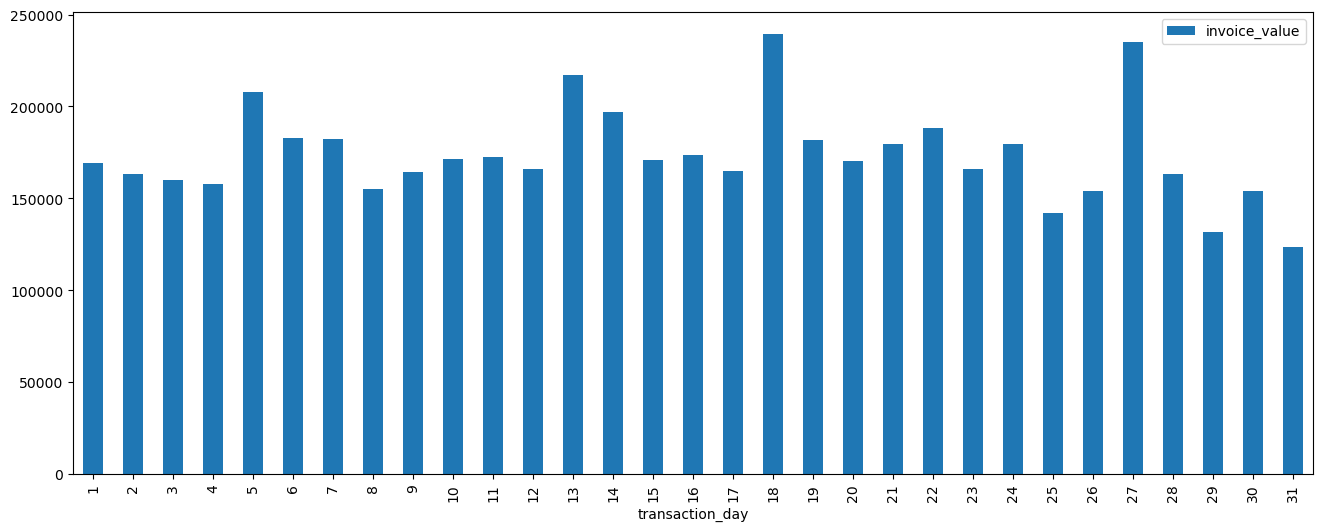

In [82]:
req2.groupby(["transaction_day"]).agg({"invoice_value":"sum"}).plot(kind="bar",figsize=(16,6))
plt.show()

# highest revenue generated in 27th and 18th day of month
# lowest revenue genrated in the last day of month

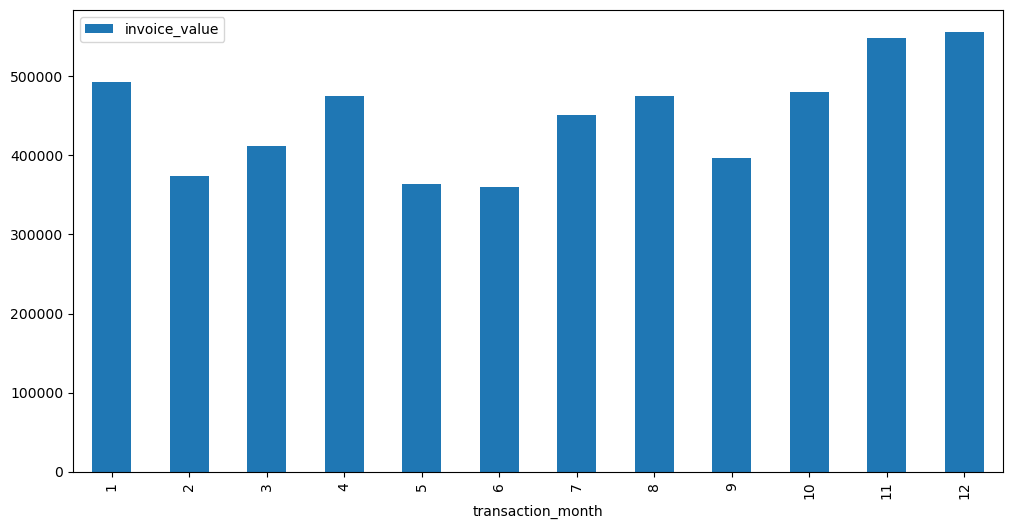

In [83]:
req2.groupby(["transaction_month"]).agg({"invoice_value":"sum"}).plot(kind="bar",figsize=(12,6))
plt.show()

# highest revenue generated in month 12 and the lowest in month 5 and 6

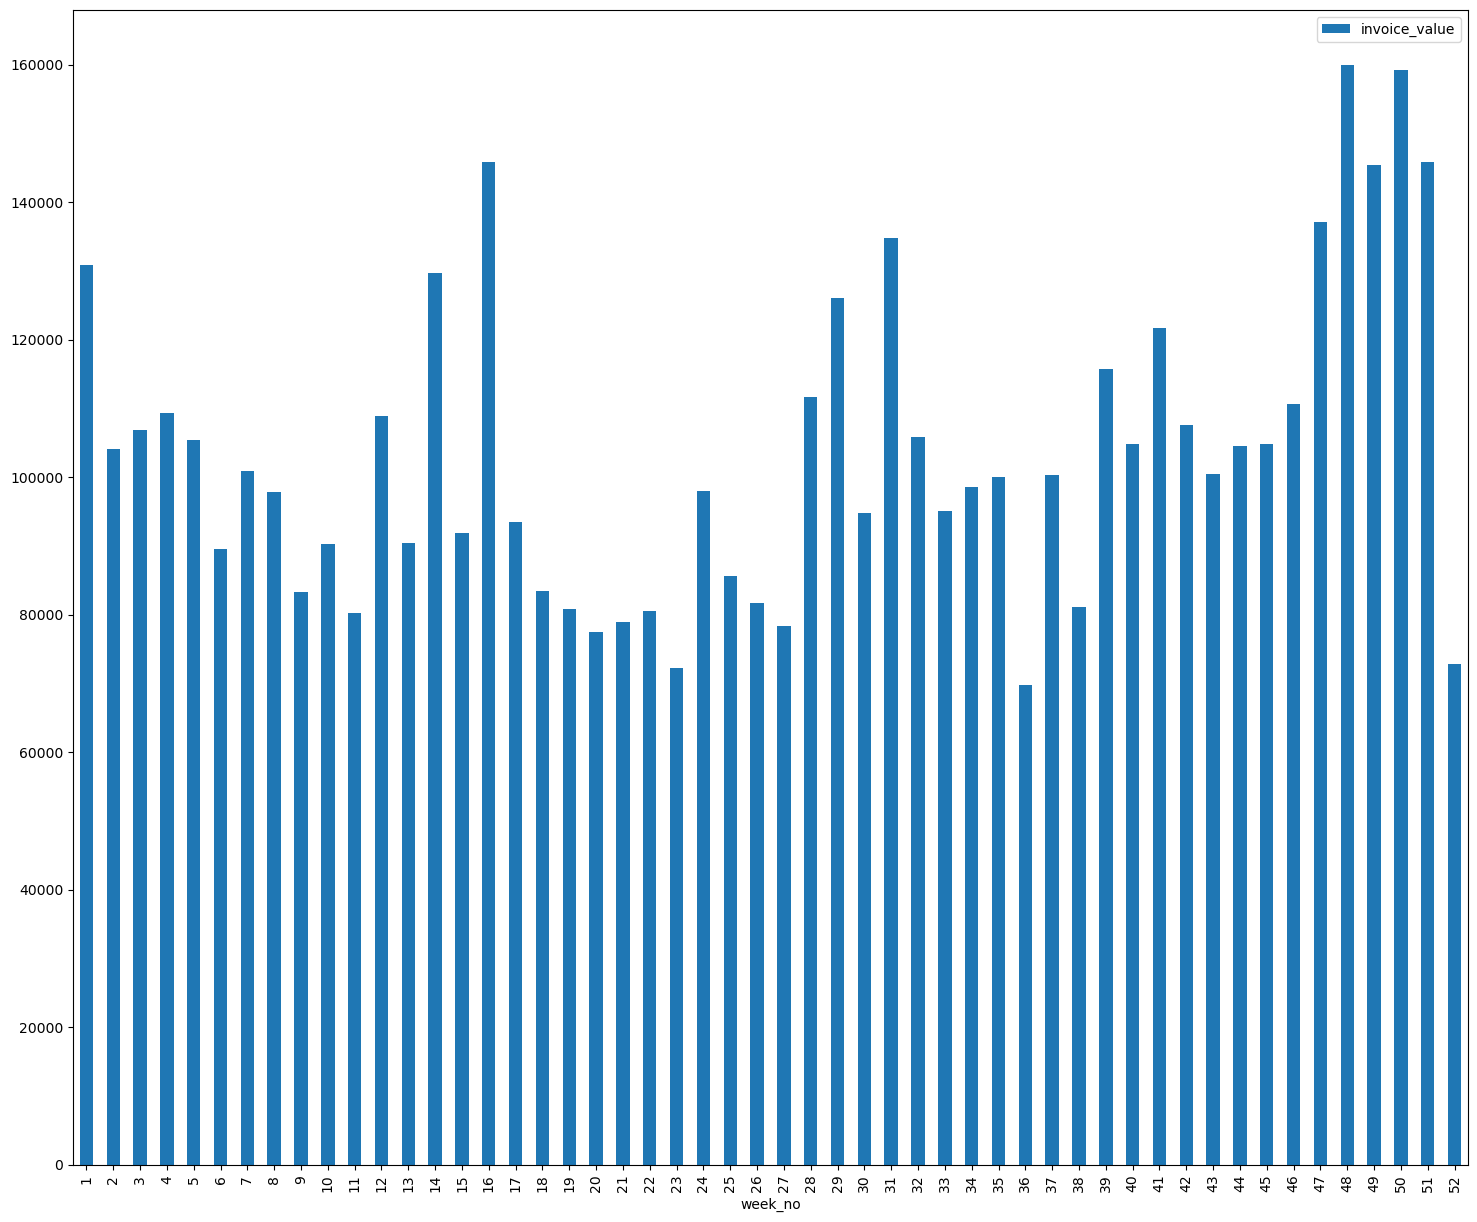

In [84]:
req2.groupby(["week_no"]).agg({"invoice_value":"sum"}).plot(kind="bar",figsize=(18,15))
plt.show()

# highest revenue generated in week 48 and 50 and lowest in 36

In [85]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust', 'new_repeat_week',
       'new_repeat_day'],
      dtype='object')

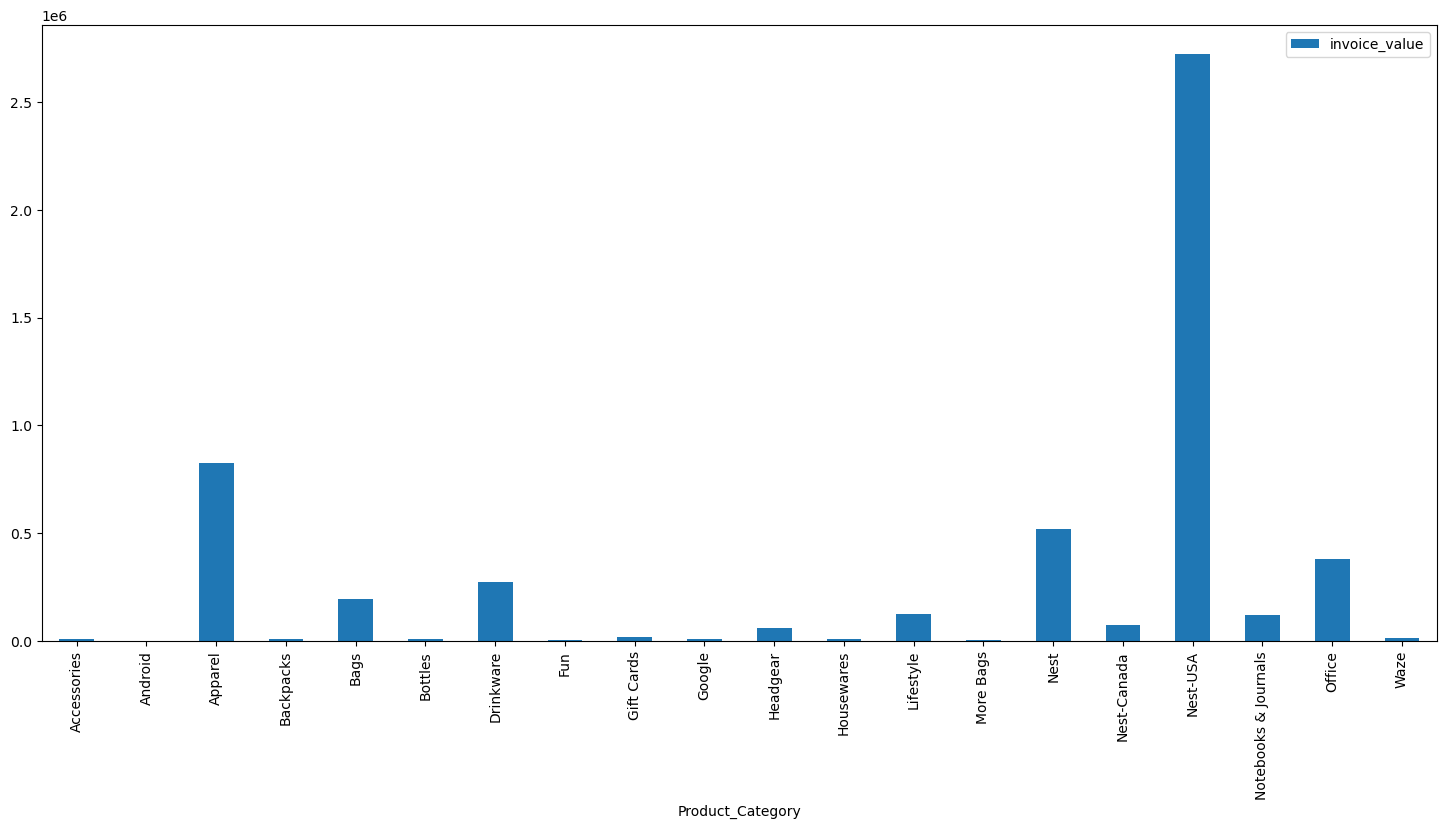

In [86]:
req2.groupby(["Product_Category"]).agg({"invoice_value":"sum"}).plot(kind="bar",figsize=(18,8))
plt.show()

# highest revenue generated is from nest USA

In [87]:
(req2.groupby(["Product_Category"]).agg({"invoice_value":"sum"})/((req2.groupby(["Product_Category"]).agg({"invoice_value":"sum"})).invoice_value.sum()))*100



# percentage sales contribution out of total sales- Nest USA constitutes 50% of sales and apparel constitutes 15% of sales

,invoice_value
Product_Category,
Accessories,0.189385
Android,0.020728
Apparel,15.371477
Backpacks,0.147347
Bags,3.595340
Bottles,0.188884
Drinkware,5.062158
Fun,0.115246
Gift Cards,0.361108


In [88]:
# analyizing number of orders by month, week,day and category

In [89]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust', 'new_repeat_week',
       'new_repeat_day'],
      dtype='object')

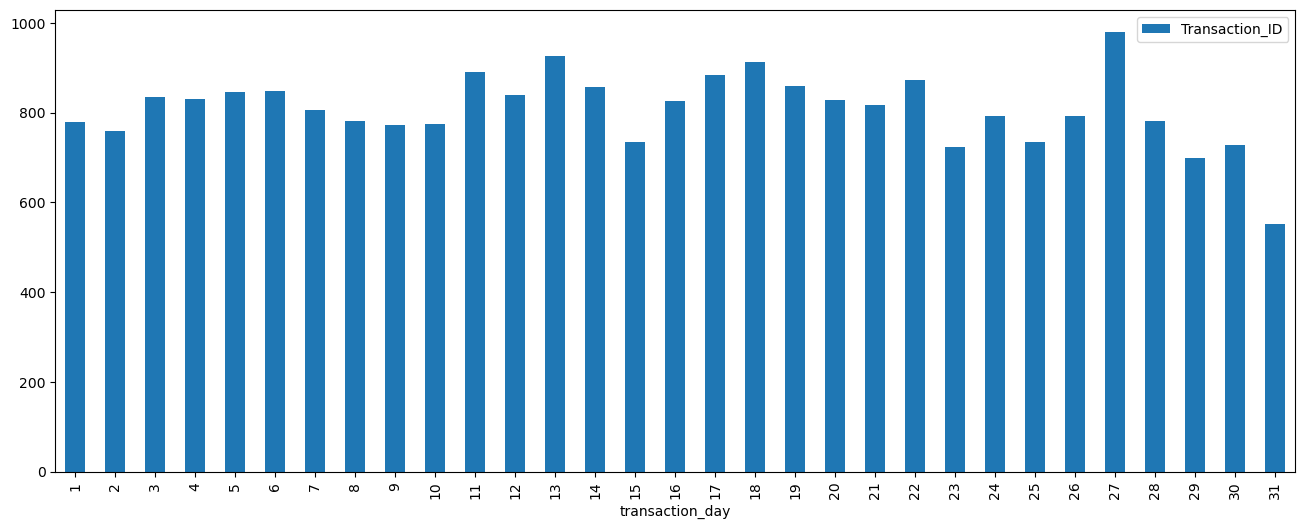

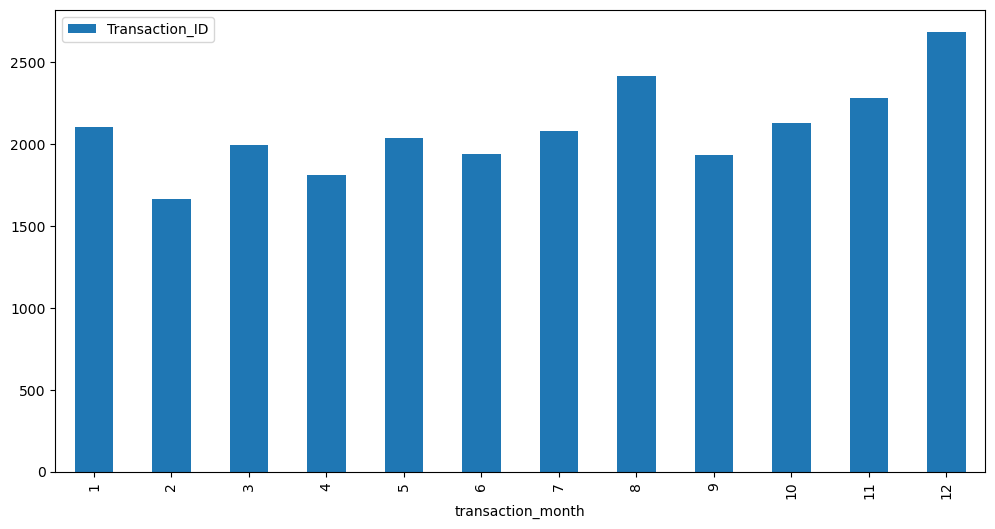

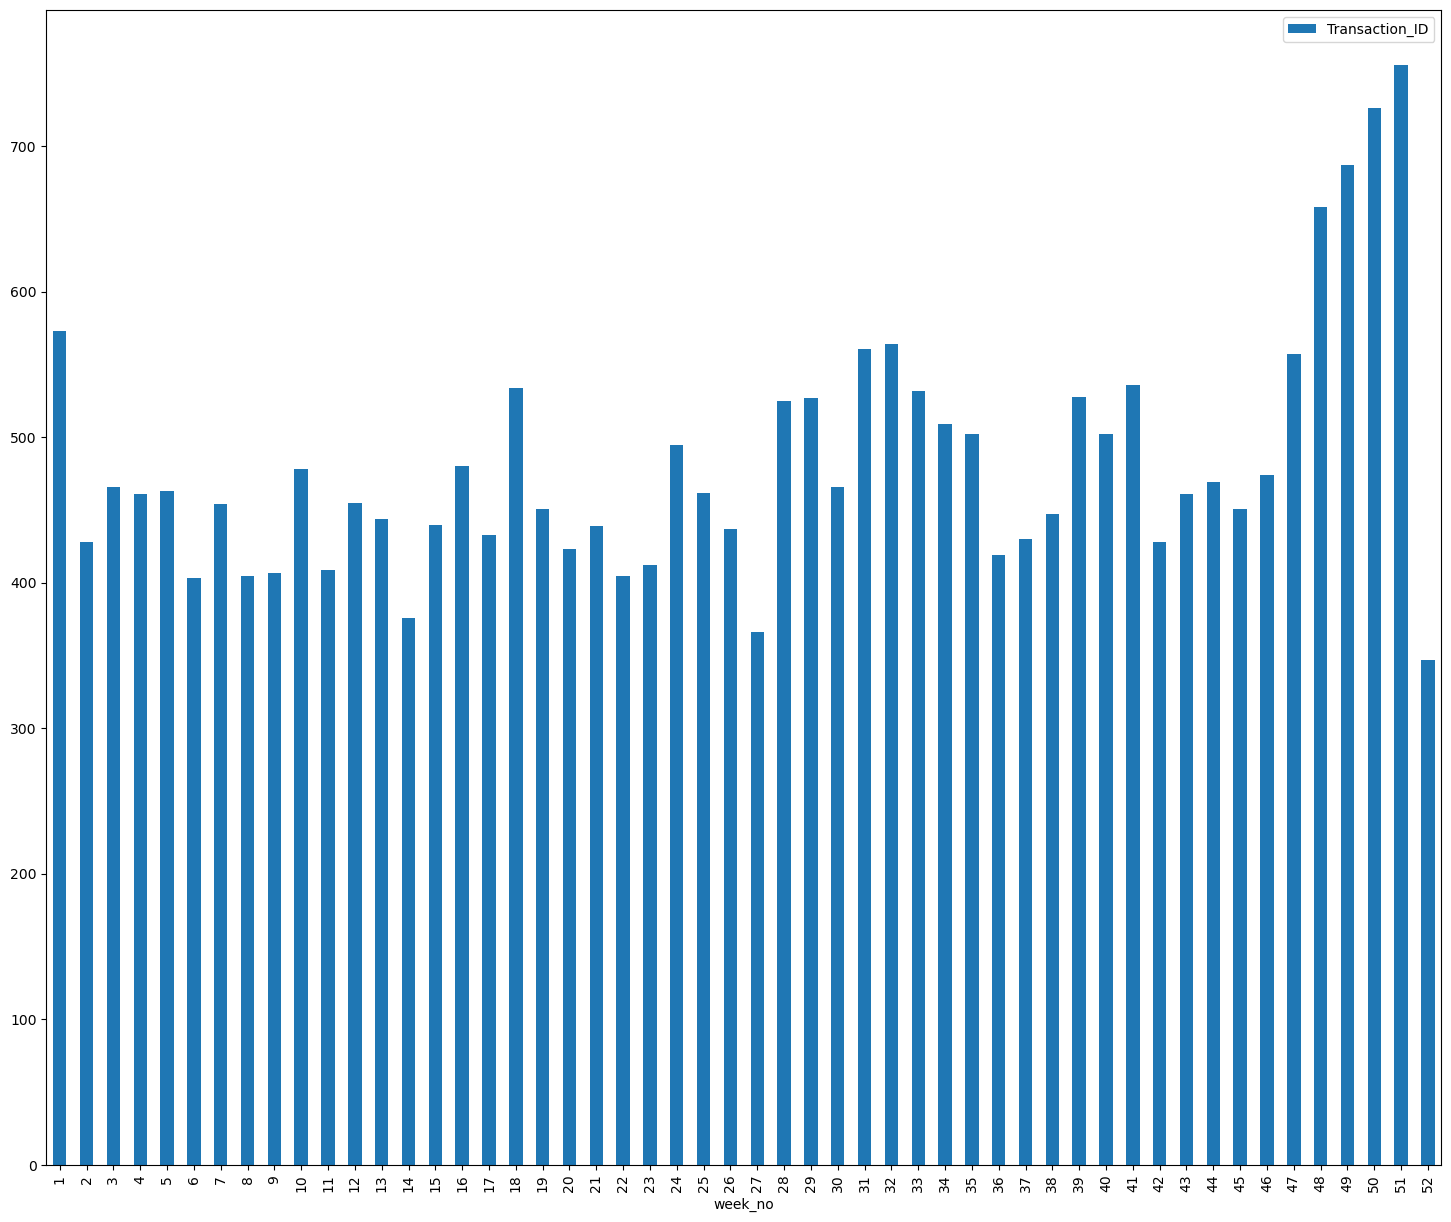

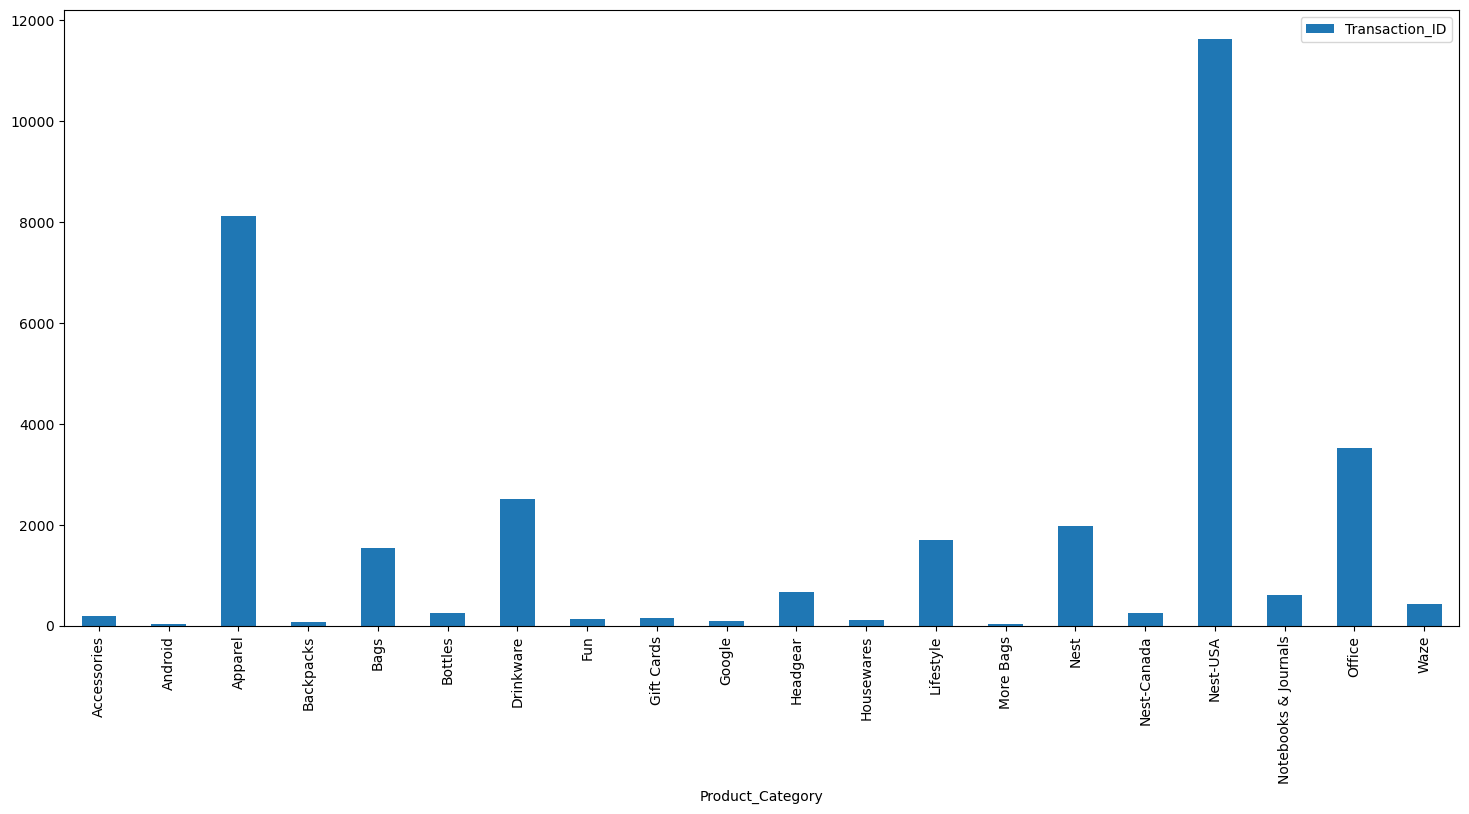

In [90]:
req2.groupby(["transaction_day"]).agg({"Transaction_ID":"nunique"}).plot(kind="bar",figsize=(16,6))
plt.show()


req2.groupby(["transaction_month"]).agg({"Transaction_ID":"nunique"}).plot(kind="bar",figsize=(12,6))
plt.show()


req2.groupby(["week_no"]).agg({"Transaction_ID":"nunique"}).plot(kind="bar",figsize=(18,15))
plt.show()



req2.groupby(["Product_Category"]).agg({"Transaction_ID":"nunique"}).plot(kind="bar",figsize=(18,8))
plt.show()



In [91]:
# no of orders highest in 28th of month and lowest in 31st of Month
# no of orders highest in last month and lowest in 2nd month
# weeks 48,49,50,51 have the highest number of orders placed

In [92]:
(req2.groupby(["Product_Category"]).agg({"Transaction_ID":"nunique"})/((req2.groupby(["Product_Category"]).agg({"Transaction_ID":"nunique"})).Transaction_ID.sum()))*100



# percentage total number of orders contribution- Nest USA constitutes 34% of orders and apparel constitutes 24% of orders

,Transaction_ID
Product_Category,
Accessories,0.558872
Android,0.125819
Apparel,23.785698
Backpacks,0.245787
Bags,4.520716
Bottles,0.754916
Drinkware,7.385300
Fun,0.427200
Gift Cards,0.459387


In [93]:
# analyzing average order value by month, category, week,day

In [94]:
q_2_e_1=req2.groupby(["transaction_month"]).agg({"invoice_value":"sum","Transaction_ID":"nunique"})

In [95]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust', 'new_repeat_week',
       'new_repeat_day'],
      dtype='object')

In [96]:
q_2_e_1["average_order_value"]=q_2_e_1.invoice_value/q_2_e_1.Transaction_ID

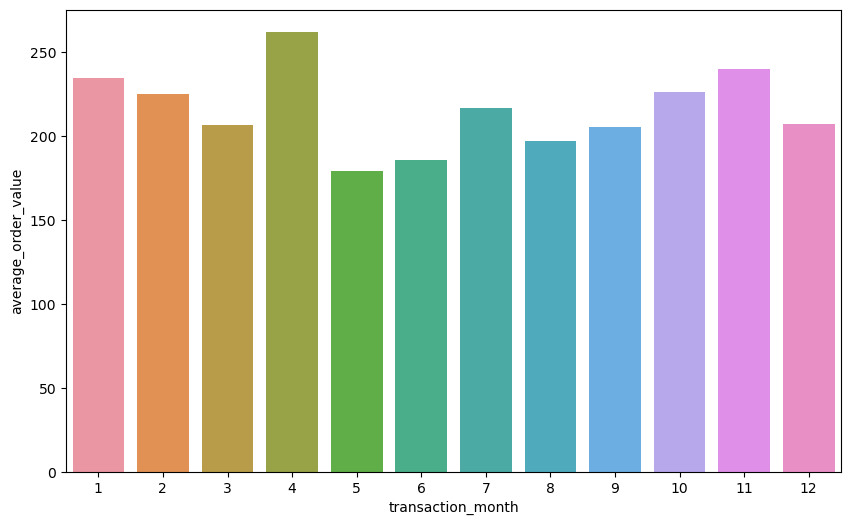

In [97]:
fig, ax = plt.subplots(figsize=(10,6)) 
sns.barplot(x=q_2_e_1.index,y=q_2_e_1.average_order_value)
plt.show()

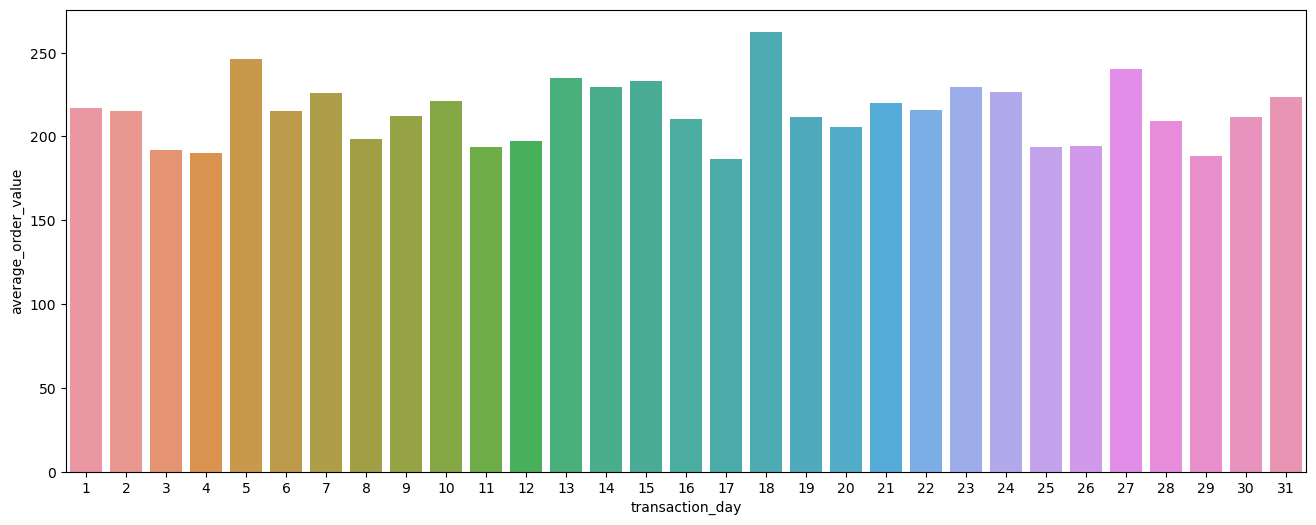

In [98]:
q_2_e_1=req2.groupby(["transaction_day"]).agg({"invoice_value":"sum","Transaction_ID":"nunique"})



q_2_e_1["average_order_value"]=q_2_e_1.invoice_value/q_2_e_1.Transaction_ID

fig, ax = plt.subplots(figsize=(16,6)) 
sns.barplot(x=q_2_e_1.index,y=q_2_e_1.average_order_value)
plt.show()

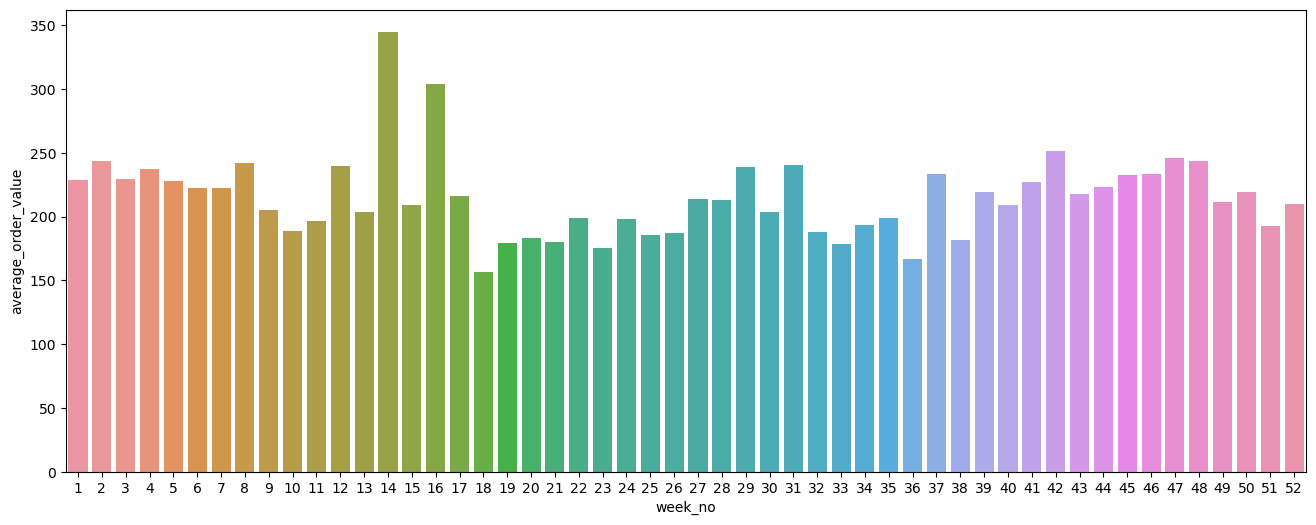

In [99]:
q_2_e_1=req2.groupby(["week_no"]).agg({"invoice_value":"sum","Transaction_ID":"nunique"})



q_2_e_1["average_order_value"]=q_2_e_1.invoice_value/q_2_e_1.Transaction_ID

fig, ax = plt.subplots(figsize=(16,6)) 
sns.barplot(x=q_2_e_1.index,y=q_2_e_1.average_order_value)
plt.show()

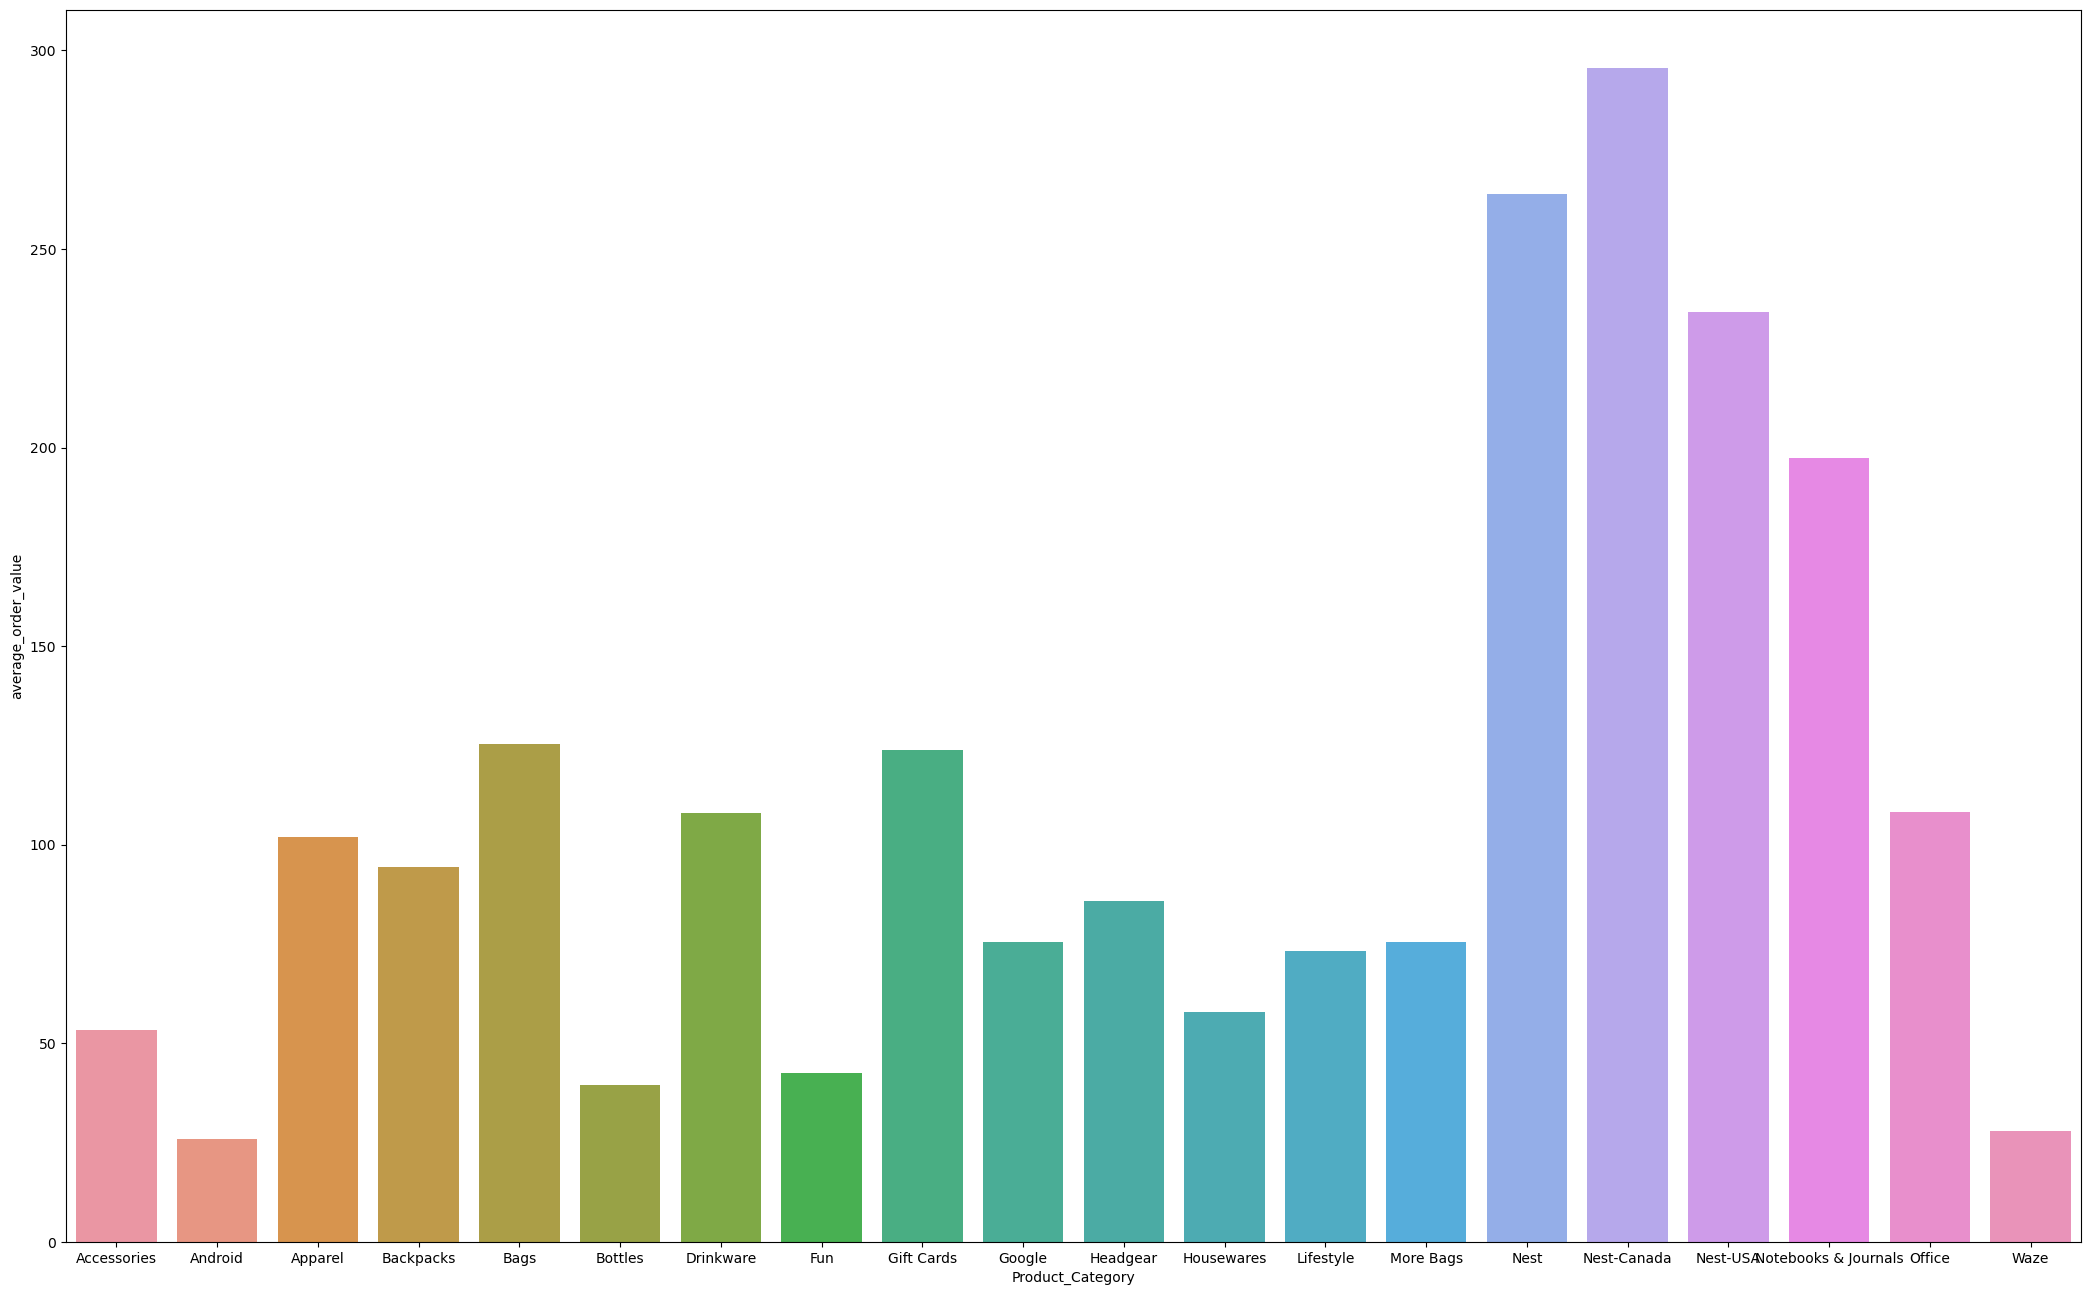

In [100]:
q_2_e_1=req2.groupby(["Product_Category"]).agg({"invoice_value":"sum","Transaction_ID":"nunique"})



q_2_e_1["average_order_value"]=q_2_e_1.invoice_value/q_2_e_1.Transaction_ID

fig, ax = plt.subplots(figsize=(26,16)) 
sns.barplot(x=q_2_e_1.index,y=q_2_e_1.average_order_value)
plt.show()

In [101]:
q_2_e_1.sort_values(by=["average_order_value"],ascending=False) ## nest canada has the highest average order value

,invoice_value,Transaction_ID,average_order_value
Product_Category,,,
Nest-Canada,7.624576e+04,258,295.526202
Nest,5.206537e+05,1974,263.755660
Nest-USA,2.721646e+06,11626,234.099927
Notebooks & Journals,1.224193e+05,620,197.450513
Bags,1.936266e+05,1545,125.324669
Gift Cards,1.944744e+04,157,123.869068
Office,3.819453e+05,3526,108.322538
Drinkware,2.726220e+05,2524,108.011872
Apparel,8.278292e+05,8129,101.836537


In [102]:
# anlyzing quantity, by category, by month, by week, by day etc…

In [103]:
req2.Quantity

0        1
1        1
2        1
3        5
4        1
        ..
52919    1
52920    1
52921    1
52922    5
52923    4
Name: Quantity, Length: 52924, dtype: int64

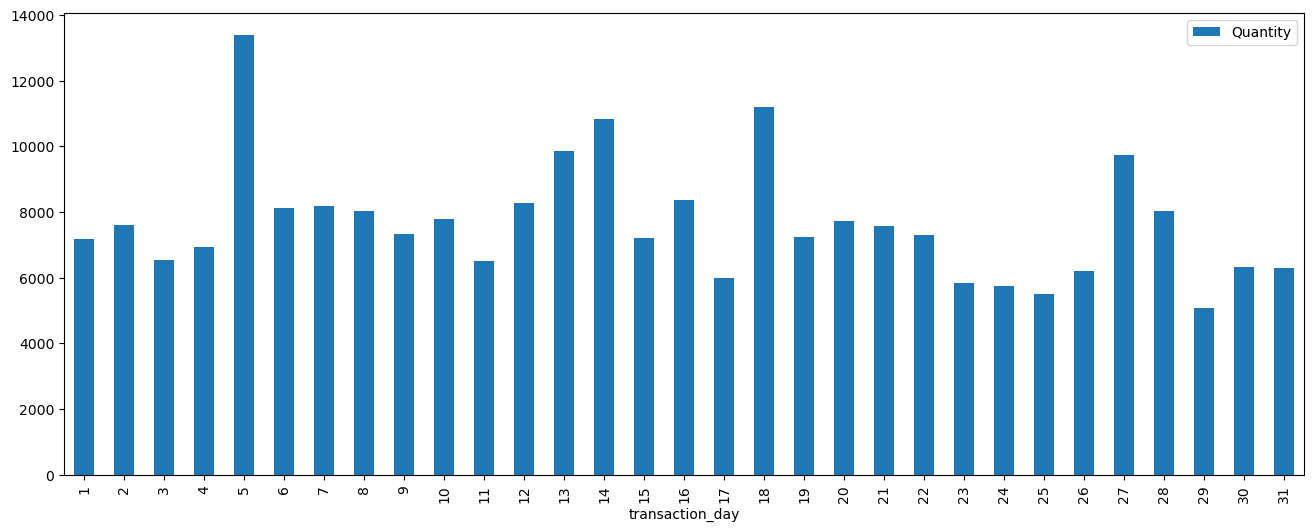

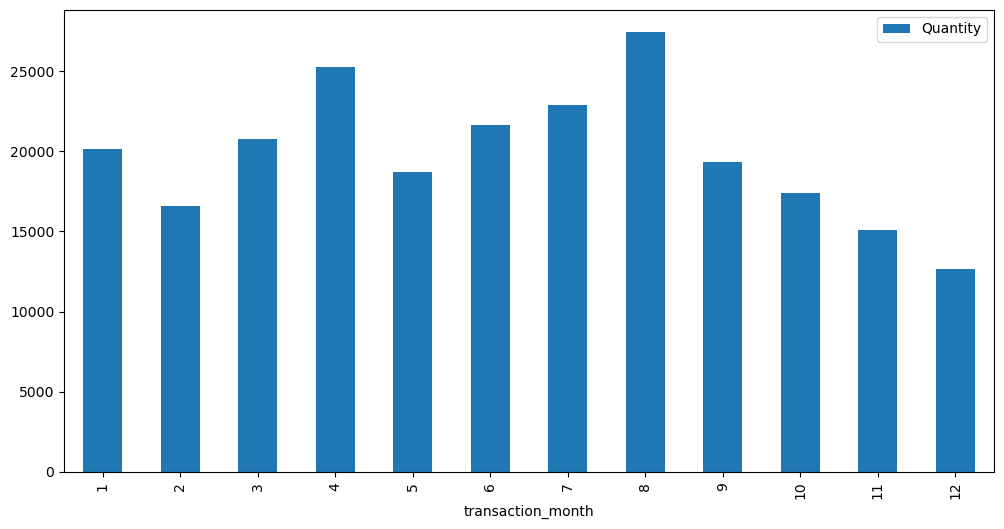

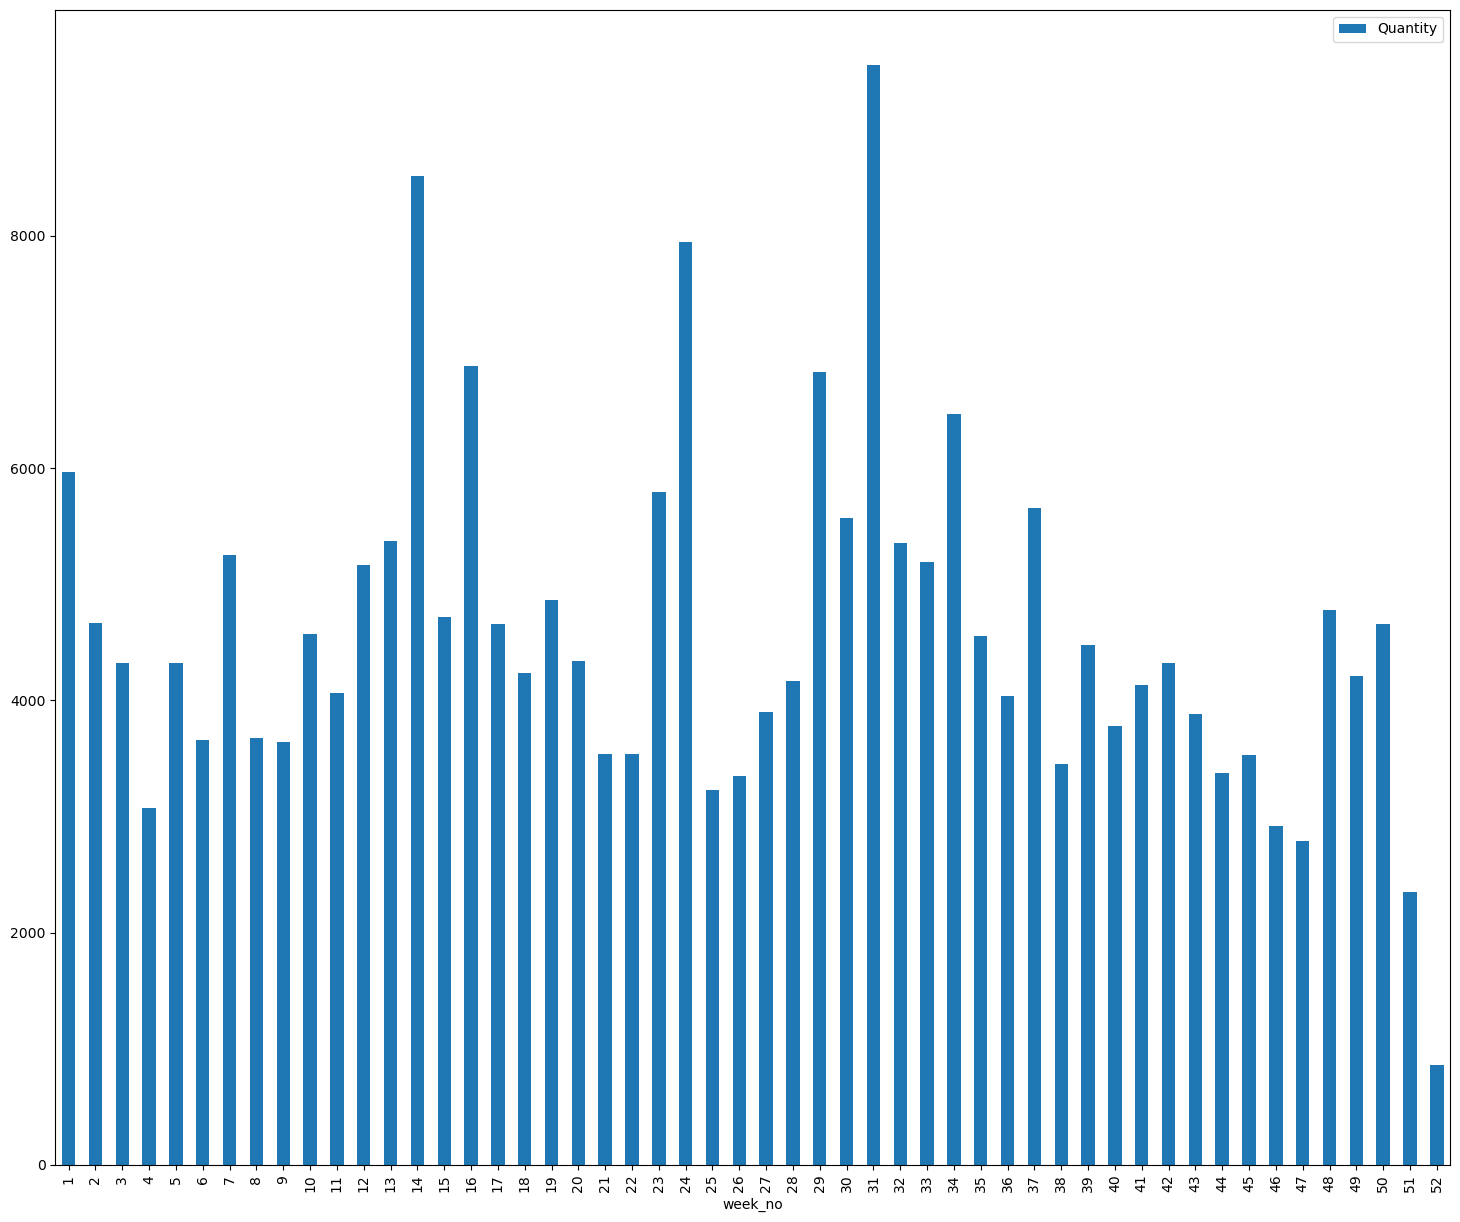

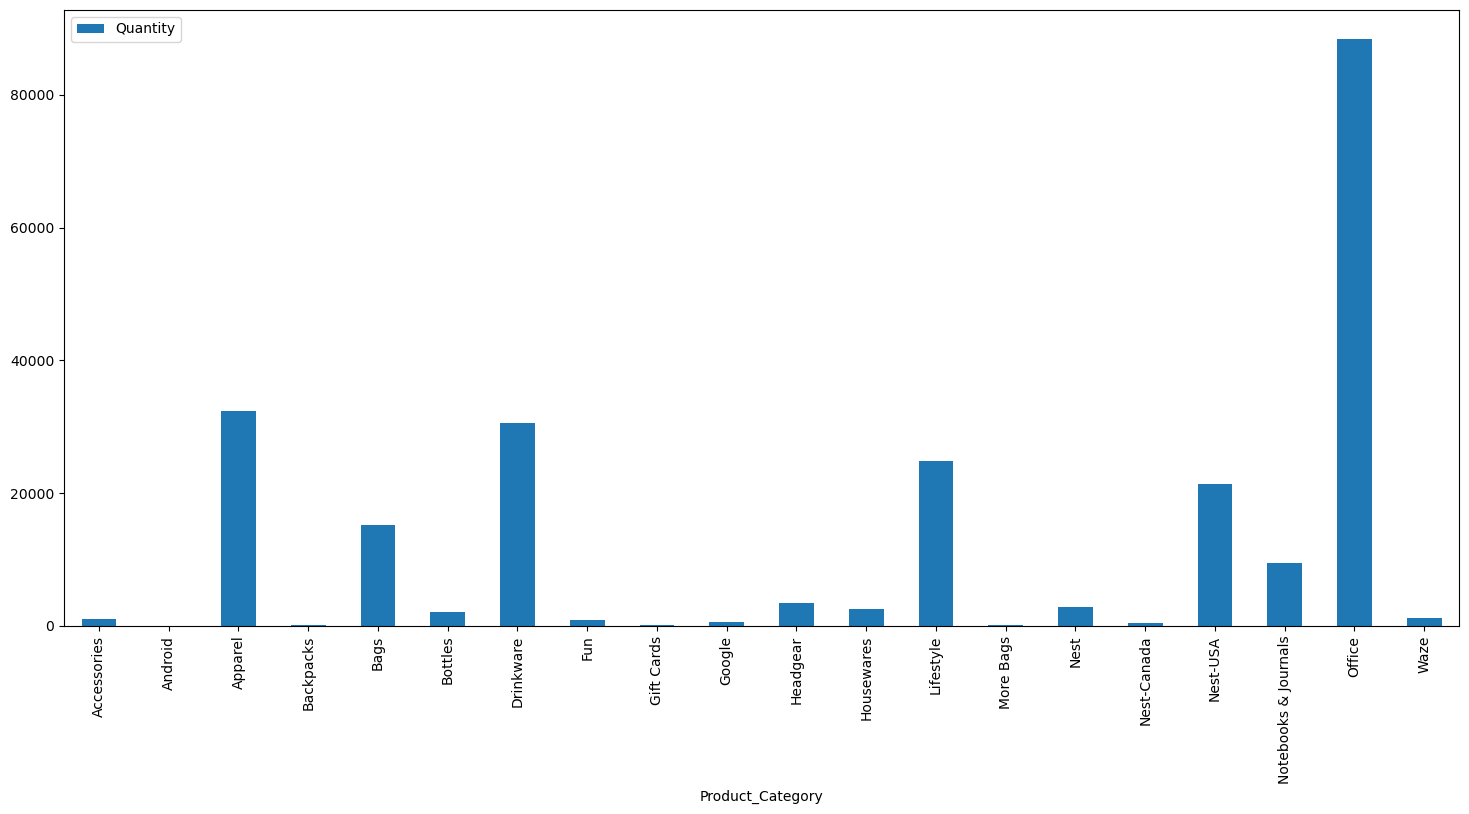

In [104]:
req2.groupby(["transaction_day"]).agg({"Quantity":"sum"}).plot(kind="bar",figsize=(16,6))
plt.show()


req2.groupby(["transaction_month"]).agg({"Quantity":"sum"}).plot(kind="bar",figsize=(12,6))
plt.show()


req2.groupby(["week_no"]).agg({"Quantity":"sum"}).plot(kind="bar",figsize=(18,15))
plt.show()



req2.groupby(["Product_Category"]).agg({"Quantity":"sum"}).plot(kind="bar",figsize=(18,8))
plt.show()


In [105]:
# highest quanitiy ordered was in month 8,day 5 of month, week 32 and of product categry office


Understand the trends/seasonality of sales by category, location, month etc…

In [106]:
#Already done in last question for sales by category, month,day and week we will find by location here

In [107]:
req3=pd.merge(left=req2,right=customer_data,how="left",left_on="CustomerID",right_on="CustomerID")

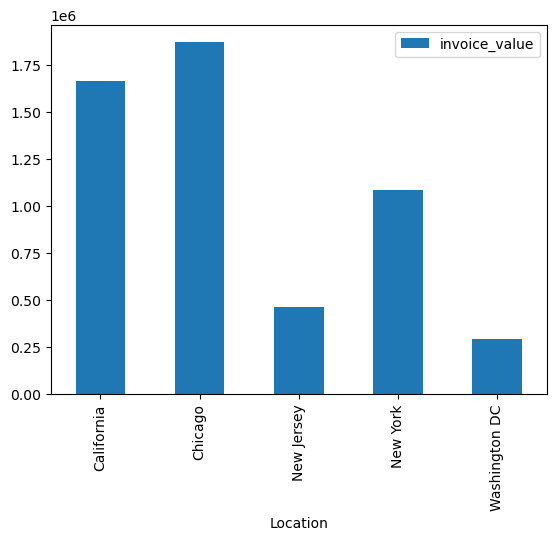

In [108]:
req3.groupby(["Location"]).agg({"invoice_value":"sum"}).plot(kind="bar")
plt.show()


# chichago generates the highest revenue
# new jersy generates the lowest revenue

How number order varies and sales with different days?

In [109]:
#Already done in last to last question

In [110]:
req2["GST_AMOUNT"]=req2.Quantity*req2.Avg_Price*(1-0.01*req2.Discount_pct)*(1+req2.GST)-req2.Quantity*req2.Avg_Price*(1-0.01*req2.Discount_pct)

In [111]:
df_1=req2.groupby(["Transaction_Date"]).agg({"invoice_value":"sum","Delivery_Charges":"sum","GST_AMOUNT":"sum"})

In [112]:
df_1=df_1.reset_index()

In [113]:
df_1.columns

Index(['Transaction_Date', 'invoice_value', 'Delivery_Charges', 'GST_AMOUNT'], dtype='object')

In [114]:
marketing_spend.dtypes # need to convert date to float

Date              object
Offline_Spend      int64
Online_Spend     float64
dtype: object

In [115]:
marketing_spend.Date=pd.to_datetime(marketing_spend.Date,format="%m/%d/%Y")

In [116]:
#we need to merge marketing_spend and df1 keeping date as key

In [117]:
df_1

,Transaction_Date,invoice_value,Delivery_Charges,GST_AMOUNT
0,2019-01-01,8989.16608,1082.23,754.67808
1,2019-01-02,15254.13876,872.00,1248.91038
2,2019-01-03,29072.26955,3650.24,2271.84759
3,2019-01-04,19413.41462,1501.94,1688.43465
4,2019-01-05,21222.00880,2411.29,1826.54118
...,...,...,...,...
360,2019-12-27,14371.81383,771.40,878.24107
361,2019-12-28,11192.15088,680.58,635.94622
362,2019-12-29,12299.47787,602.87,807.70879
363,2019-12-30,8440.30569,411.18,483.10605


In [118]:
df2=pd.merge(left=df_1,right=marketing_spend,left_on="Transaction_Date",right_on="Date")

In [119]:
df2["total_marketing_spend"]=df2.Online_Spend+df2.Offline_Spend

In [120]:
df2["month"]=df2.Date.dt.month

In [121]:
df3=df2.groupby(["month"]).agg({"invoice_value":"sum","Delivery_Charges":"sum","GST_AMOUNT":"sum","total_marketing_spend":"sum"})

<Axes: xlabel='month'>

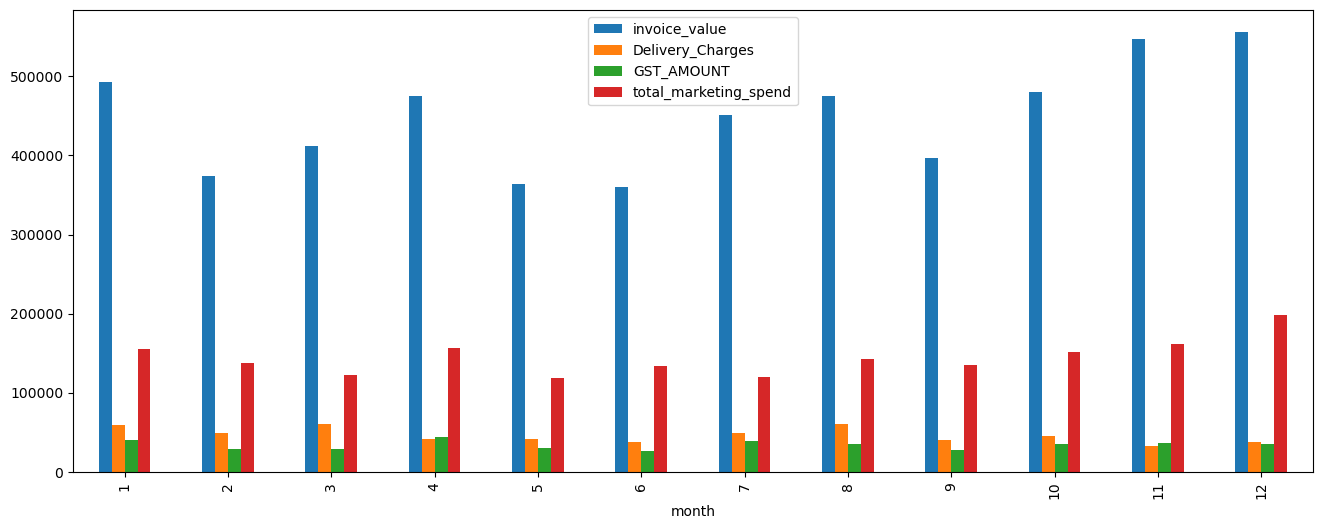

In [122]:
df3.plot(kind="bar",figsize=(16,6))

In [123]:
df3["percentage_marketing_spend"]=(df3.total_marketing_spend/df3.invoice_value)*100

In [124]:
df3["percentage_GST_Contribution"]=(df3.GST_AMOUNT/df3.invoice_value)*100

In [125]:
df3["delivery_charges_Contribution"]=(df3.Delivery_Charges/df3.invoice_value)*100

In [126]:
df3

,invoice_value,Delivery_Charges,GST_AMOUNT,total_marketing_spend,percentage_marketing_spend,percentage_GST_Contribution,delivery_charges_Contribution
month,,,,,,,
1,493209.34775,59242.32,40735.93545,154928.95,31.412412,8.259360,12.011597
2,374383.14890,49216.60,29217.46720,137107.92,36.622353,7.804162,13.146051
3,411621.80564,60799.94,29618.97043,122250.09,29.699615,7.195676,14.770826
4,475184.08242,41481.74,43884.85203,157026.83,33.045473,9.235337,8.729615
5,364377.16876,41396.17,29726.55536,118259.64,32.455283,8.158183,11.360802
6,360411.47389,37513.58,26712.18571,134318.14,37.267998,7.411580,10.408542
7,450566.39084,48723.93,39197.84661,120217.85,26.681495,8.699683,10.813929
8,475048.52294,61099.57,35547.34784,142904.15,30.082011,7.482888,12.861753
9,396348.56674,41005.42,27428.09398,135514.54,34.190748,6.920195,10.345797


In [127]:
df2

,Transaction_Date,invoice_value,Delivery_Charges,GST_AMOUNT,Date,Offline_Spend,Online_Spend,total_marketing_spend,month
0,2019-01-01,8989.16608,1082.23,754.67808,2019-01-01,4500,2424.50,6924.50,1
1,2019-01-02,15254.13876,872.00,1248.91038,2019-01-02,4500,3480.36,7980.36,1
2,2019-01-03,29072.26955,3650.24,2271.84759,2019-01-03,4500,1576.38,6076.38,1
3,2019-01-04,19413.41462,1501.94,1688.43465,2019-01-04,4500,2928.55,7428.55,1
4,2019-01-05,21222.00880,2411.29,1826.54118,2019-01-05,4500,4055.30,8555.30,1
...,...,...,...,...,...,...,...,...,...
360,2019-12-27,14371.81383,771.40,878.24107,2019-12-27,4000,3396.87,7396.87,12
361,2019-12-28,11192.15088,680.58,635.94622,2019-12-28,4000,3246.84,7246.84,12
362,2019-12-29,12299.47787,602.87,807.70879,2019-12-29,4000,2546.58,6546.58,12
363,2019-12-30,8440.30569,411.18,483.10605,2019-12-30,4000,674.31,4674.31,12


How marketing spend is impacting on revenue?

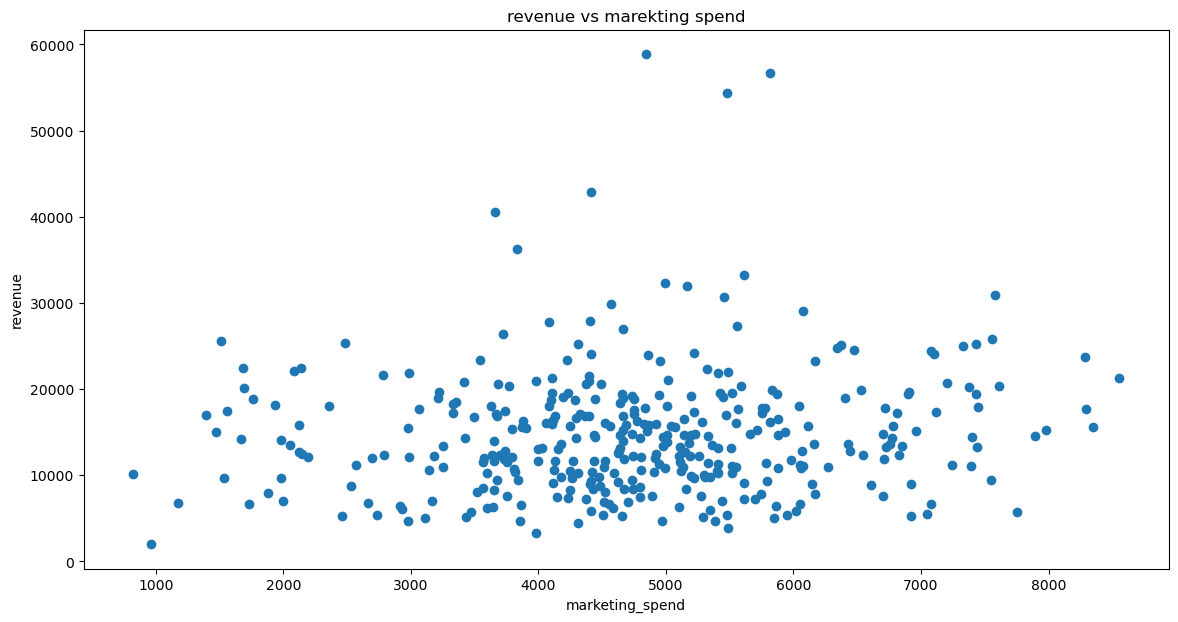

In [128]:
plt.figure(figsize=(14,7))
plt.scatter(x=df2.total_marketing_spend,y=df2.invoice_value)
plt.xlabel("marketing_spend")
plt.ylabel("revenue")
plt.title("revenue vs marekting spend")
plt.show()


In [129]:
# increase in marketing spend has not increased revenue

 Which product was appeared in the transactions?

In [130]:
df4=req2.groupby(["Transaction_ID","Product_Description"]).agg({"Product_Description":"count"}).add_prefix("count_of")

In [131]:
df5=df4.pivot_table(index="Transaction_ID",columns="Product_Description",values="count_ofProduct_Description")

In [132]:
df5=df5.reset_index()

In [133]:
list2=[]

In [134]:
for i in list(df5.columns):
    i=i.replace(" ","_")
    list2.append(i)

In [135]:
df5.columns=list2

In [136]:
list_unique_transaction_id=list(set(req2.Transaction_ID))

In [137]:
dict3={}
for i in list_unique_transaction_id:
    dict3[i]=set(req2[req2.Transaction_ID==i].Product_Description)
    



In [138]:
dict3

{16679: {'Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'},
 16680: {'Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'},
 16681: {'Google Laptop and Cell Phone Stickers'},
 16682: {'Badge Holder',
  'Engraved Ceramic Google Mug',
  'Galaxy Screen Cleaning Cloth',
  'Google 22 oz Water Bottle',
  'Google Canvas Tote Natural/Navy',
  'Google Infuser-Top Water Bottle',
  "Google Men's 100% Cotton Short Sleeve Hero Tee Black",
  'Maze Pen',
  'Sport Bag',
  "YouTube Men's Short Sleeve Hero Tee Black"},
 16684: {'Nest Cam Outdoor Security Camera - USA',
  'Nest Protect Smoke + CO White Wired Alarm-USA'},
 16685: {"Google Men's 100% Cotton Short Sleeve Hero Tee Red",
  "Google Women's Short Sleeve Hero Tee White",
  'Red Shine 15 oz Mug'},
 16687: {'Ballpoint LED Light Pen',
  'Color Changing Grip Pen',
  'Colored Pencil Set',
  'Compact Selfie Stick',
  'Maze Pen',
  'Spiral Notebook and Pen Set'},
 16688: {'Nest Cam Indoor Security Camera - USA'},
 16689: {'Nest Learning The

In [139]:
unique_prod_desc_list=list(set(req2.Product_Description))

In [140]:
dict4={}
for i in unique_prod_desc_list:
    dict4[i]=list(set(req2[req2.Product_Description==i].Transaction_ID))

In [141]:
len(list((set(req2[req2.Product_Description==unique_prod_desc_list[0]].Transaction_ID))))

81

In [142]:
list3=[]
list4=[]
for i,k in dict4.items():
    list3.append(i)
    z=len(k)
    list4.append(z)

In [143]:
len(list3)

404

In [144]:
len(list4)

404

In [145]:
ser1=pd.Series(list3,name="name_of_product")

In [146]:
ser2=pd.Series(list4,name="number_of_transactions")

In [147]:
df6=pd.concat([ser1,ser2],axis=1)

In [148]:
df6.sort_values(by=["number_of_transactions"],ascending=False)

,name_of_product,number_of_transactions
305,Nest Learning Thermostat 3rd Gen-USA - Stainle...,3511
108,Nest Cam Outdoor Security Camera - USA,3328
38,Nest Cam Indoor Security Camera - USA,3230
365,Nest Protect Smoke + CO White Battery Alarm-USA,1361
210,Nest Learning Thermostat 3rd Gen-USA - White,1089
...,...,...
115,Google Women's Performance Polo Grey/Black,1
320,Google Women's Colorblock Tee White,1
302,Google Men's Heavyweight Long Sleeve Hero Tee ...,1
4,Android Women's Short Sleeve Tri-blend Badge T...,1


In [149]:
# nest Learning Thermostat 3 rd Generation Stainless stell appeared in most transactions

which product was purchased mostly based on the quantity?

In [150]:
req2.groupby(["Product_Description"]).agg({"Quantity":"sum"}).sort_values(by=["Quantity"],ascending=False)

,Quantity
Product_Description,
Maze Pen,16234
Google 22 oz Water Bottle,14282
Google Sunglasses,11452
Sport Bag,7321
Google Metallic Notebook Set,6496
...,...
Google Tee Red,3
Android 5-Panel Low Cap,3
Compact Journal with Recycled Pages,1


In [151]:
# maza pen was purchased mostly based on quantity

3. Performing Customer Segmentation

a Heuristic (Value based, RFM) – Divide the customers into Premium, Gold, Silver, 
Standard customers and define strategy on the same. 

b Scientific (Using K-Means) & Understand the profiles. Define strategy for each 
segment.

In [152]:
req2

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,product_categgory_sales_table,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Discount_pct,primary_key,Product_Category,GST,updated_dis_per,invoice_value,new_old_cust,new_repeat_week,new_repeat_day,GST_AMOUNT
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,10.0,JanNest-USA,Nest-USA,0.10,10.0,158.67290,new,new,new,13.83390
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,10.0,JanNest-USA,Nest-USA,0.10,10.0,158.67290,new,new,new,13.83390
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,10.0,JanOffice,Office,0.10,10.0,8.52950,new,new,new,0.18450
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,10.0,JanApparel,Apparel,0.18,0.0,109.92700,new,new,new,14.19930
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,10.0,JanBags,Bags,0.18,10.0,24.02300,new,new,new,2.67300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,...,30.0,DecNest-USA,Nest-USA,0.10,0.0,139.93000,new,new,repeat,8.49100
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,...,30.0,DecApparel,Apparel,0.18,30.0,46.90792,new,new,repeat,6.16392
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,...,30.0,DecNest-USA,Nest-USA,0.10,30.0,123.44760,new,new,repeat,10.63160
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,...,30.0,DecNest-USA,Nest-USA,0.10,0.0,449.36000,new,new,repeat,28.18200


In [153]:
list_unique_cust_id=list(set(req2.CustomerID))

In [154]:
dict5={}
for i in list_unique_cust_id:
    dict5[i]=list(set(req2[req2.CustomerID==i].Transaction_ID))

In [155]:
list5=[]
list6=[]
for i,k in dict5.items():
    list5.append(i)
    z=len(k)
    list6.append(z)
    

In [156]:
ser3=pd.Series(list5,name="cust_id")

In [157]:
ser4=pd.Series(list6,name="no_of_transactions")

In [158]:
df_cust=pd.concat([ser3,ser4],axis=1)

In [159]:
dict6={}
for i in list_unique_cust_id:
    dict6[i]=list(set(req2[req2.CustomerID==i].Transaction_Date))

In [160]:
list7=[]
list8=[]
list9=[]
for i,k in dict6.items():
    list7.append(i)
    z1=max(k)
    z2=min(k)
    list8.append(z1)
    list9.append(z2)

In [161]:
ser5=pd.Series(list7,name="cust_id")
ser6=pd.Series(list8,name="latest_transaction_date")
ser7=pd.Series(list9,name="first_transaction_date")

In [162]:
df_cust_1=pd.concat([ser5,ser6,ser7],axis=1)
df_cust_1 # the first and latest transacation date for each customers

,cust_id,latest_transaction_date,first_transaction_date
0,16385,2019-04-04,2019-04-03
1,16387,2019-10-02,2019-10-02
2,16393,2019-05-06,2019-02-23
3,16395,2019-09-26,2019-08-28
4,16401,2019-09-05,2019-09-05
...,...,...,...
1463,16353,2019-12-20,2019-02-15
1464,16359,2019-09-04,2019-08-22
1465,16365,2019-06-09,2019-03-27
1466,16367,2019-05-06,2019-05-06


In [163]:
df_cust # no of unique transactions per customers

,cust_id,no_of_transactions
0,16385,9
1,16387,2
2,16393,13
3,16395,39
4,16401,10
...,...,...
1463,16353,9
1464,16359,4
1465,16365,6
1466,16367,14


In [164]:
df8=req2.groupby(["CustomerID","Product_Category"]).agg({"Product_Category":"count"}).add_prefix("count_of").reset_index()

In [165]:
df8.columns

Index(['CustomerID', 'Product_Category', 'count_ofProduct_Category'], dtype='object')

In [166]:
df8=df8.pivot_table(index="CustomerID",columns="Product_Category",values="count_ofProduct_Category")

In [167]:
df8=df8.reset_index()

In [168]:
df8

Product_Category,CustomerID,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gift Cards,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
0,12346,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,12347,1.0,NaN,19.0,NaN,2.0,NaN,2.0,NaN,NaN,...,1.0,NaN,1.0,NaN,2.0,NaN,20.0,NaN,11.0,NaN
2,12348,NaN,NaN,4.0,NaN,2.0,NaN,3.0,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,7.0,NaN
3,12350,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,2.0,6.0,NaN,NaN,NaN
4,12356,NaN,NaN,15.0,NaN,1.0,NaN,3.0,NaN,NaN,...,NaN,NaN,4.0,NaN,2.0,NaN,4.0,NaN,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
1464,18260,1.0,NaN,17.0,NaN,1.0,1.0,2.0,1.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,6.0,4.0,4.0,1.0
1465,18269,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1466,18277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [169]:
list11=[]
for i in list(df8.columns):
    i=i.replace(" ","")
    list11.append(i)
    
    

df8.columns=list11

df8

,CustomerID,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,GiftCards,...,Headgear,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze
0,12346,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,12347,1.0,NaN,19.0,NaN,2.0,NaN,2.0,NaN,NaN,...,1.0,NaN,1.0,NaN,2.0,NaN,20.0,NaN,11.0,NaN
2,12348,NaN,NaN,4.0,NaN,2.0,NaN,3.0,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,2.0,NaN,7.0,NaN
3,12350,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,2.0,6.0,NaN,NaN,NaN
4,12356,NaN,NaN,15.0,NaN,1.0,NaN,3.0,NaN,NaN,...,NaN,NaN,4.0,NaN,2.0,NaN,4.0,NaN,7.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
1464,18260,1.0,NaN,17.0,NaN,1.0,1.0,2.0,1.0,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,6.0,4.0,4.0,1.0
1465,18269,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1466,18277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [170]:
for i in df8.columns.difference(["CustomerID"]):
    df8[i]=IF(df8[i]>0,1,0)

In [171]:
df8

,CustomerID,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,GiftCards,...,Headgear,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze
0,12346,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,12347,1,0,1,0,1,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
2,12348,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3,12350,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,12356,0,0,1,0,1,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1464,18260,1,0,1,0,1,1,1,1,0,...,1,0,0,0,0,0,1,1,1,1
1465,18269,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1466,18277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [172]:
df_cust

,cust_id,no_of_transactions
0,16385,9
1,16387,2
2,16393,13
3,16395,39
4,16401,10
...,...,...
1463,16353,9
1464,16359,4
1465,16365,6
1466,16367,14


In [173]:
df_cust2=req2.groupby(["CustomerID"]).agg({"invoice_value":"sum"}).reset_index() # to find the revenue/inovice value for customers

In [174]:
df_cust2

,CustomerID,invoice_value
0,12346,174.98174
1,12347,15686.84396
2,12348,1689.55594
3,12350,1467.43528
4,12356,2007.42900
...,...,...
1463,18259,860.68600
1464,18260,3016.54372
1465,18269,166.90750
1466,18277,333.80000


In [175]:
customer_data

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49
...,...,...,...,...
1463,14438,F,New York,41
1464,12956,F,Chicago,48
1465,15781,M,New Jersey,19
1466,14410,F,New York,45


In [176]:
merge1=pd.merge(left=customer_data,right=df_cust,left_on="CustomerID",right_on="cust_id")

In [177]:
merge1.drop(columns=["cust_id"],inplace=True)

In [178]:
merge1

,CustomerID,Gender,Location,Tenure_Months,no_of_transactions
0,17850,M,Chicago,12,177
1,13047,M,California,43,26
2,12583,M,Chicago,33,15
3,13748,F,California,30,1
4,15100,M,California,49,6
...,...,...,...,...,...
1463,14438,F,New York,41,5
1464,12956,F,Chicago,48,14
1465,15781,M,New Jersey,19,3
1466,14410,F,New York,45,6


In [179]:
df_cust_1.columns

Index(['cust_id', 'latest_transaction_date', 'first_transaction_date'], dtype='object')

In [180]:
merge2=pd.merge(left=merge1,right=df_cust_1,left_on="CustomerID",right_on="cust_id")

In [181]:
merge2.drop(columns=["CustomerID"],inplace=True)

In [182]:
df_cust2

,CustomerID,invoice_value
0,12346,174.98174
1,12347,15686.84396
2,12348,1689.55594
3,12350,1467.43528
4,12356,2007.42900
...,...,...
1463,18259,860.68600
1464,18260,3016.54372
1465,18269,166.90750
1466,18277,333.80000


In [183]:
merge3=pd.merge(left=merge2,right=df_cust2,left_on="cust_id",right_on="CustomerID")

In [184]:
merge3.drop(columns="CustomerID",inplace=True)

In [185]:
merge3

,Gender,Location,Tenure_Months,no_of_transactions,cust_id,latest_transaction_date,first_transaction_date,invoice_value
0,M,Chicago,12,177,17850,2019-01-26,2019-01-01,40489.88124
1,M,California,43,26,13047,2019-12-18,2019-01-01,3348.77498
2,M,Chicago,33,15,12583,2019-08-02,2019-01-01,3320.84496
3,F,California,30,1,13748,2019-01-01,2019-01-01,7.96320
4,M,California,49,6,15100,2019-08-30,2019-01-01,967.73992
...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,14438,2019-12-31,2019-12-30,546.93384
1464,F,Chicago,48,14,12956,2019-12-31,2019-12-31,3286.15547
1465,M,New Jersey,19,3,15781,2019-12-31,2019-12-31,835.90202
1466,F,New York,45,6,14410,2019-12-31,2019-12-31,1183.13702


In [186]:
df8

,CustomerID,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,GiftCards,...,Headgear,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze
0,12346,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,12347,1,0,1,0,1,0,1,0,0,...,1,0,1,0,1,0,1,0,1,0
2,12348,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
3,12350,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
4,12356,0,0,1,0,1,0,1,0,0,...,0,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,18259,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1464,18260,1,0,1,0,1,1,1,1,0,...,1,0,0,0,0,0,1,1,1,1
1465,18269,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1466,18277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [187]:
merge4=pd.merge(left=merge3,right=df8,left_on="cust_id",right_on="CustomerID")

In [188]:
merge4.drop(columns=["cust_id"],inplace=True)

In [189]:
merge4

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,Headgear,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,1,1,1,0,0,1,1,1,1,1
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,1,0,1,0,1,0,1,0,1,1
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,1,1,1,0,0,0,1,1,1,0
3,F,California,30,1,2019-01-01,2019-01-01,7.96320,13748,0,0,...,0,0,1,0,0,0,0,0,0,0
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,2019-12-31,2019-12-30,546.93384,14438,1,0,...,0,0,0,0,0,0,1,0,1,0
1464,F,Chicago,48,14,2019-12-31,2019-12-31,3286.15547,12956,0,0,...,0,0,0,0,1,0,1,0,1,0
1465,M,New Jersey,19,3,2019-12-31,2019-12-31,835.90202,15781,0,0,...,0,0,0,0,0,0,1,0,0,0
1466,F,New York,45,6,2019-12-31,2019-12-31,1183.13702,14410,0,0,...,0,0,0,0,1,0,1,0,0,0


In [190]:
# value based segmentation will be divided based on revenue generated from each customers


<Axes: >

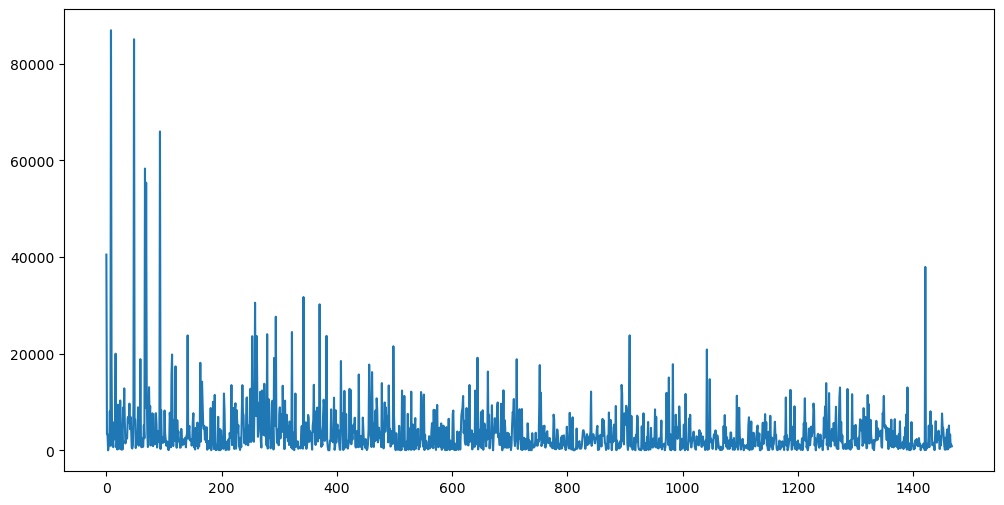

In [191]:
merge4.invoice_value.plot(figsize=(12,6))

as we see most of the customers are below 20,000 we will divide the customer based on the revenue as per following
1. Less than 3000-standard
2. 3000-6000 silver
3. 6000-9000 gold
4. more than 9000 -premimum

In [192]:
merge4["values_based_segment"]=IF(merge4.invoice_value<3000,"standard",IF(merge4.invoice_value<6000,"silver",IF(merge4.invoice_value<9000,"gold","premium")))

In [193]:
merge4.values_based_segment.value_counts()

values_based_segment
standard    920
silver      288
gold        133
premium     127
Name: count, dtype: int64

In [194]:
merge4.columns

Index(['Gender', 'Location', 'Tenure_Months', 'no_of_transactions',
       'latest_transaction_date', 'first_transaction_date', 'invoice_value',
       'CustomerID', 'Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'MoreBags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks&Journals', 'Office', 'Waze',
       'values_based_segment'],
      dtype='object')

In [195]:
merge4.groupby(["values_based_segment"]).agg({"Nest":"sum"})

,Nest
values_based_segment,
gold,76
premium,89
silver,147
standard,204


In [196]:
x1=['Gender','Location']

In [197]:
x2=['Tenure_Months', 'no_of_transactions']

In [198]:
x3=[ 'Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'MoreBags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks&Journals', 'Office', 'Waze']

In [199]:
list12=[]
for i in list(merge4.columns):
    i=i.replace(" ","_")
    list12.append(i)
    

In [200]:
merge4.columns=list12

In [201]:
merge4.columns

Index(['Gender', 'Location', 'Tenure_Months', 'no_of_transactions',
       'latest_transaction_date', 'first_transaction_date', 'invoice_value',
       'CustomerID', 'Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'MoreBags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks&Journals', 'Office', 'Waze',
       'values_based_segment'],
      dtype='object')

In [202]:
for i in x1:
    print(merge4.groupby([i,"values_based_segment"]).agg({i:"count"}))
    print("-----------------------------------------------")

                             Gender
Gender values_based_segment        
F      gold                      76
       premium                   78
       silver                   182
       standard                 598
M      gold                      57
       premium                   49
       silver                   106
       standard                 322
-----------------------------------------------
                                    Location
Location      values_based_segment          
California    gold                        44
              premium                     40
              silver                      75
              standard                   305
Chicago       gold                        38
              premium                     40
              silver                     107
              standard                   271
New Jersey    gold                        11
              premium                      9
              silver                      27
       

In [203]:
for i in x2:
    print(merge4.groupby(["values_based_segment"]).agg({i:"mean"}))
    print("------------------------------------------")
    
    

                      Tenure_Months
values_based_segment               
gold                      25.894737
premium                   26.236220
silver                    25.784722
standard                  25.909783
------------------------------------------
                      no_of_transactions
values_based_segment                    
gold                           35.406015
premium                        71.181102
silver                         22.305556
standard                        7.019565
------------------------------------------


In [204]:
for i in x3:
    print(merge4.groupby(["values_based_segment"]).agg({i:"sum"}))
    print("-----------------------------------------------")
    

                      Accessories
values_based_segment             
gold                           18
premium                        48
silver                         43
standard                       41
-----------------------------------------------
                      Android
values_based_segment         
gold                        7
premium                     9
silver                     14
standard                   12
-----------------------------------------------
                      Apparel
values_based_segment         
gold                      133
premium                   126
silver                    282
standard                  782
-----------------------------------------------
                      Backpacks
values_based_segment           
gold                         16
premium                      29
silver                       17
standard                     13
-----------------------------------------------
                      Bags
values_based_segment     

1. Less than 3000-standard
2. 3000-6000 silver
3. 6000-9000 gold
4. more than 9000 -premimum




Scientific segementation

In [205]:
merge4

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,values_based_segment
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,1,1,0,0,1,1,1,1,1,premium
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,0,1,0,1,0,1,0,1,1,silver
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,1,1,0,0,0,1,1,1,0,silver
3,F,California,30,1,2019-01-01,2019-01-01,7.96320,13748,0,0,...,0,1,0,0,0,0,0,0,0,standard
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,0,0,0,0,1,0,0,0,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,2019-12-31,2019-12-30,546.93384,14438,1,0,...,0,0,0,0,0,1,0,1,0,standard
1464,F,Chicago,48,14,2019-12-31,2019-12-31,3286.15547,12956,0,0,...,0,0,0,1,0,1,0,1,0,silver
1465,M,New Jersey,19,3,2019-12-31,2019-12-31,835.90202,15781,0,0,...,0,0,0,0,0,1,0,0,0,standard
1466,F,New York,45,6,2019-12-31,2019-12-31,1183.13702,14410,0,0,...,0,0,0,1,0,1,0,0,0,standard


for scientic segmentaion we will be dropping columns customerid, lastest_transaction_date,first_transaction_date and values based segmenet

In [206]:
merge4.columns

Index(['Gender', 'Location', 'Tenure_Months', 'no_of_transactions',
       'latest_transaction_date', 'first_transaction_date', 'invoice_value',
       'CustomerID', 'Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags',
       'Bottles', 'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'MoreBags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'Notebooks&Journals', 'Office', 'Waze',
       'values_based_segment'],
      dtype='object')

In [207]:
seg_data=merge4.drop(columns=["CustomerID","values_based_segment","latest_transaction_date", "first_transaction_date"])

In [208]:
seg_data

,Gender,Location,Tenure_Months,no_of_transactions,invoice_value,Accessories,Android,Apparel,Backpacks,Bags,...,Headgear,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze
0,M,Chicago,12,177,40489.88124,0,0,1,1,1,...,1,1,1,0,0,1,1,1,1,1
1,M,California,43,26,3348.77498,0,0,1,0,0,...,1,0,1,0,1,0,1,0,1,1
2,M,Chicago,33,15,3320.84496,0,0,1,0,1,...,1,1,1,0,0,0,1,1,1,0
3,F,California,30,1,7.96320,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,M,California,49,6,967.73992,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,546.93384,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1464,F,Chicago,48,14,3286.15547,0,0,1,0,0,...,0,0,0,0,1,0,1,0,1,0
1465,M,New Jersey,19,3,835.90202,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1466,F,New York,45,6,1183.13702,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0


In [209]:
# we will create dummies for variable gender and location

In [210]:
location_dummy=pd.get_dummies(seg_data.Location,drop_first=True)

In [211]:
gender_dummy=pd.get_dummies(seg_data.Gender,drop_first=True)

In [212]:
gender_dummy

,M
0,True
1,True
2,True
3,False
4,True
...,...
1463,False
1464,False
1465,True
1466,False


In [213]:
seg_data=pd.concat([seg_data,location_dummy,gender_dummy],axis=1)

In [214]:
seg_data.drop(columns=["Location","Gender"],inplace=True)

In [215]:
# we will use standard scaler to standardize the data

In [216]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA   

In [217]:
sc=StandardScaler()

In [218]:
std_model=sc.fit(seg_data)

In [219]:
std_model.transform(seg_data)

array([[-0.99693398,  6.36252764,  6.33008463, ..., -0.53218116,
        -0.23203584,  1.32252171],
       [ 1.22450613,  0.31476375, -0.05498045, ..., -0.53218116,
        -0.23203584,  1.32252171],
       [ 0.50791255, -0.12580183, -0.05978201, ..., -0.53218116,
        -0.23203584,  1.32252171],
       ...,
       [-0.49531847, -0.60641882, -0.48697775, ..., -0.53218116,
        -0.23203584,  1.32252171],
       [ 1.36782485, -0.48626457, -0.42728329, ...,  1.87905939,
        -0.23203584, -0.75613126],
       [-1.35523077, -0.64647024, -0.4890861 , ..., -0.53218116,
        -0.23203584, -0.75613126]])

In [220]:
seg_data_standardized=pd.DataFrame(std_model.transform(seg_data),columns=seg_data.columns)

In [221]:
# we will do PCA to feature reduction in segmentation standardized data

In [222]:
PCA?

In [223]:
seg_data_standardized.shape

(1468, 28)

In [224]:
list13=[]
for i in list(seg_data_standardized.columns):
    i=i.replace(" ","_")
    list13.append(i)

In [225]:
seg_data_standardized.columns=list13

In [226]:
pca_model=PCA(n_components=28)

In [227]:
pca_model=pca_model.fit(seg_data_standardized)

In [228]:
pca_model.explained_variance_  

array([5.16151616, 1.56214672, 1.41381509, 1.34855073, 1.19044547,
       1.12710505, 1.05353279, 1.03262614, 0.98660533, 0.95959722,
       0.93111362, 0.88008094, 0.87881186, 0.85932186, 0.82639572,
       0.81812162, 0.78531534, 0.75986359, 0.74105152, 0.7164973 ,
       0.67613305, 0.65755288, 0.59470142, 0.56433908, 0.54022503,
       0.51299148, 0.39821064, 0.04241892])

In [229]:
# we will select componenets which explain at least 0.8 of variance and total variables explainign around 80% of variance

In [230]:
pca_model.explained_variance_ratio_

array([0.18421429, 0.05575295, 0.050459  , 0.04812972, 0.04248695,
       0.04022633, 0.03760054, 0.03685438, 0.0352119 , 0.03424798,
       0.03323141, 0.03141005, 0.03136476, 0.03066916, 0.02949403,
       0.02919873, 0.02802787, 0.0271195 , 0.0264481 , 0.02557176,
       0.02413116, 0.02346803, 0.02122487, 0.02014124, 0.01928061,
       0.01830864, 0.01421212, 0.00151393])

In [231]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.18421429, 0.23996724, 0.29042624, 0.33855596, 0.38104291,
       0.42126924, 0.45886978, 0.49572416, 0.53093606, 0.56518405,
       0.59841545, 0.6298255 , 0.66119026, 0.69185942, 0.72135345,
       0.75055217, 0.77858004, 0.80569954, 0.83214764, 0.8577194 ,
       0.88185056, 0.90531859, 0.92654346, 0.9466847 , 0.96596531,
       0.98427395, 0.99848607, 1.        ])

In [232]:
#we will select 18 components

In [233]:
pca_model=PCA(n_components=18)

In [234]:
pca_model=pca_model.fit(seg_data_standardized)

In [235]:
pca_model.transform(seg_data_standardized)

array([[ 1.01435684e+01,  4.72315539e+00,  3.16806869e+00, ...,
        -1.00976654e+00,  3.90937719e-01,  2.45649733e+00],
       [ 9.17052985e-01, -9.62273562e-01, -1.31398684e+00, ...,
         5.37149929e-01,  1.78928697e-01, -8.10421666e-01],
       [ 1.68225695e+00, -6.88263575e-01,  1.27255850e+00, ...,
         2.31411168e-01,  2.14220427e+00,  3.49216848e-01],
       ...,
       [-2.54952361e+00,  5.37569894e-01,  1.16323667e-01, ...,
        -3.47374537e-01, -1.10415114e-03,  4.83717886e-01],
       [-2.17799752e+00,  2.79883228e-01, -7.77407276e-01, ...,
        -6.25269559e-01, -6.14292403e-01,  6.70853573e-01],
       [-3.02899231e+00,  1.86511039e+00,  3.73204801e-01, ...,
         5.87987493e-01,  6.87723431e-01,  1.14757025e+00]])

In [236]:
list14=[]
for i in range(1,19):
    z="PCA"+str(i)
    list14.append(z)

In [237]:
list14

['PCA1',
 'PCA2',
 'PCA3',
 'PCA4',
 'PCA5',
 'PCA6',
 'PCA7',
 'PCA8',
 'PCA9',
 'PCA10',
 'PCA11',
 'PCA12',
 'PCA13',
 'PCA14',
 'PCA15',
 'PCA16',
 'PCA17',
 'PCA18']

In [238]:
pca_df=pd.DataFrame(pca_model.transform(seg_data_standardized),columns=list14)

In [239]:
# calculating factor loadings

In [240]:
Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T,columns=seg_data_standardized.columns).T



In [241]:
Loadings.columns=list14

In [242]:
Loadings.to_csv("loadongs.csv")

In [243]:
selected_variables=["Tenure_Months",
"no_of_transactions",
"Android",
"Apparel",
"Gift_Cards",
"Google",
"Headgear",
"Nest",
"Nest-Canada",
"Nest-USA",
"Chicago",
"New_Jersey",
"New_York",
"Washington_DC",
"M"]


In [244]:
#after using PCA for variable reduction , we will be using these variables for segmentation 

In [245]:
seg_data_standardized.columns=['Tenure_Months', 'no_of_transactions', 'invoice_value', 'Accessories',
       'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles', 'Drinkware',
       'Fun', 'Gift_Cards', 'Google', 'Headgear', 'Housewares', 'Lifestyle',
       'MoreBags', 'Nest', 'Nest-Canada', 'Nest-USA', 'Notebooks&Journals',
       'Office', 'Waze', 'Chicago', 'New_Jersey', 'New_York', 'Washington_DC',
       'M']

In [246]:
input_segmentation=seg_data_standardized[selected_variables]

In [247]:
input_segmentation

,Tenure_Months,no_of_transactions,Android,Apparel,Gift_Cards,Google,Headgear,Nest,Nest-Canada,Nest-USA,Chicago,New_Jersey,New_York,Washington_DC,M
0,-0.996934,6.362528,-0.171619,0.331058,-0.235278,3.936290,1.566562,-0.736218,2.482131,0.406300,1.489731,-0.336102,-0.532181,-0.232036,1.322522
1,1.224506,0.314764,-0.171619,0.331058,-0.235278,-0.254046,1.566562,1.358294,-0.402880,0.406300,-0.671262,-0.336102,-0.532181,-0.232036,1.322522
2,0.507913,-0.125802,-0.171619,0.331058,-0.235278,-0.254046,1.566562,-0.736218,-0.402880,0.406300,1.489731,-0.336102,-0.532181,-0.232036,1.322522
3,0.292934,-0.686522,-0.171619,-3.020619,-0.235278,-0.254046,-0.638340,-0.736218,-0.402880,-2.461238,-0.671262,-0.336102,-0.532181,-0.232036,-0.756131
4,1.654462,-0.486265,-0.171619,0.331058,-0.235278,-0.254046,-0.638340,-0.736218,-0.402880,0.406300,-0.671262,-0.336102,-0.532181,-0.232036,1.322522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,1.081187,-0.526316,-0.171619,-3.020619,-0.235278,-0.254046,-0.638340,-0.736218,-0.402880,0.406300,-0.671262,-0.336102,1.879059,-0.232036,-0.756131
1464,1.582803,-0.165853,-0.171619,0.331058,-0.235278,-0.254046,-0.638340,1.358294,-0.402880,0.406300,1.489731,-0.336102,-0.532181,-0.232036,-0.756131
1465,-0.495318,-0.606419,-0.171619,0.331058,-0.235278,-0.254046,-0.638340,-0.736218,-0.402880,0.406300,-0.671262,2.975290,-0.532181,-0.232036,1.322522
1466,1.367825,-0.486265,-0.171619,0.331058,-0.235278,-0.254046,-0.638340,1.358294,-0.402880,0.406300,-0.671262,-0.336102,1.879059,-0.232036,-0.756131


In [248]:
#Lets start with k=3 and till k=8 and check how the above paramtere varies

In [249]:
k_3=KMeans(n_clusters=3,random_state=123).fit(input_segmentation)
k_4=KMeans(n_clusters=4,random_state=123).fit(input_segmentation)
k_5=KMeans(n_clusters=5,random_state=123).fit(input_segmentation)
k_6=KMeans(n_clusters=6,random_state=123).fit(input_segmentation)
k_7=KMeans(n_clusters=7,random_state=123).fit(input_segmentation)
k_8=KMeans(n_clusters=8,random_state=123).fit(input_segmentation)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_k

In [250]:
seg_data["cluster_3"]=k_3.labels_

In [251]:
seg_data

,Tenure_Months,no_of_transactions,invoice_value,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,...,Nest-USA,Notebooks&Journals,Office,Waze,Chicago,New Jersey,New York,Washington DC,M,cluster_3
0,12,177,40489.88124,0,0,1,1,1,1,1,...,1,1,1,1,True,False,False,False,True,2
1,43,26,3348.77498,0,0,1,0,0,0,1,...,1,0,1,1,False,False,False,False,True,1
2,33,15,3320.84496,0,0,1,0,1,0,1,...,1,1,1,0,True,False,False,False,True,1
3,30,1,7.96320,0,0,0,0,0,0,0,...,0,0,0,0,False,False,False,False,False,0
4,49,6,967.73992,0,0,1,0,1,0,1,...,1,0,0,0,False,False,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,41,5,546.93384,1,0,0,0,0,0,1,...,1,0,1,0,False,False,True,False,False,0
1464,48,14,3286.15547,0,0,1,0,0,0,1,...,1,0,1,0,True,False,False,False,False,1
1465,19,3,835.90202,0,0,1,0,0,0,0,...,1,0,0,0,False,True,False,False,True,1
1466,45,6,1183.13702,0,0,1,0,0,0,0,...,1,0,0,0,False,False,True,False,False,1


In [252]:
seg_data["cluster_4"]=k_4.labels_
seg_data["cluster_5"]=k_5.labels_
seg_data["cluster_6"]=k_6.labels_
seg_data["cluster_7"]=k_7.labels_
seg_data["cluster_8"]=k_8.labels_

In [253]:
seg_data

,Tenure_Months,no_of_transactions,invoice_value,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,...,New Jersey,New York,Washington DC,M,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,12,177,40489.88124,0,0,1,1,1,1,1,...,False,False,False,True,2,3,4,2,4,3
1,43,26,3348.77498,0,0,1,0,0,0,1,...,False,False,False,True,1,0,2,1,2,2
2,33,15,3320.84496,0,0,1,0,1,0,1,...,False,False,False,True,1,1,1,3,2,0
3,30,1,7.96320,0,0,0,0,0,0,0,...,False,False,False,False,0,2,0,5,6,7
4,49,6,967.73992,0,0,1,0,1,0,1,...,False,False,False,True,1,0,2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,41,5,546.93384,1,0,0,0,0,0,1,...,False,True,False,False,0,2,2,5,1,2
1464,48,14,3286.15547,0,0,1,0,0,0,1,...,False,False,False,False,1,1,1,3,2,0
1465,19,3,835.90202,0,0,1,0,0,0,0,...,True,False,False,True,1,0,2,0,3,5
1466,45,6,1183.13702,0,0,1,0,0,0,0,...,False,True,False,False,1,0,2,1,1,2


In [254]:
# we will first find SC score for all the segements starting from 3
k_range = range(3, 9)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=123)
    km.fit(input_segmentation)
    scores.append(silhouette_score(input_segmentation, km.labels_))





C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_k

In [255]:
scores

[0.14018603400727842,
 0.12930576400417806,
 0.151701289038016,
 0.17354721123231354,
 0.19106191408050796,
 0.18957038989884537]

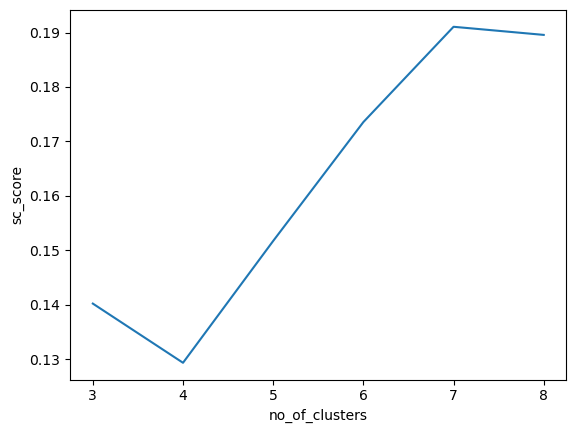

In [256]:
plt.plot(k_range,scores)
plt.xlabel("no_of_clusters")
plt.ylabel("sc_score")
plt.show()


# 7 segmenets is giving us highest sc score

In [257]:
# we will also do elbow analysis to cross check this

In [258]:
cluster_range = range( 3, 9 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(n_clusters=num_clusters)
    clusters.fit(input_segmentation)
    cluster_errors.append(clusters.inertia_)


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_k

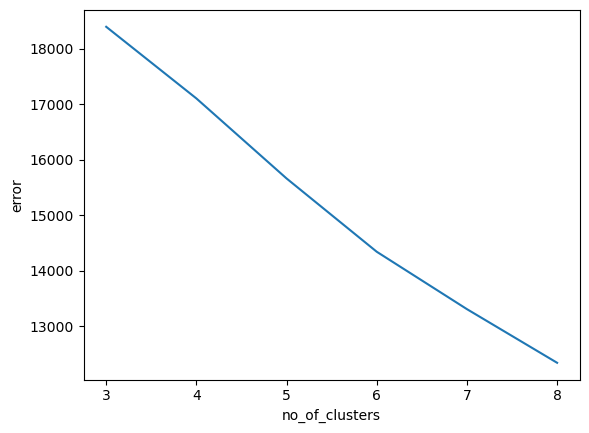

In [259]:
plt.plot(cluster_range,cluster_errors)
plt.xlabel("no_of_clusters")
plt.ylabel("error")
plt.show()  # the line appears to be almost straight and hence nothing can be figured out from this

In [260]:
#from clsuter 3 to 8 we will check segemnet distribution

In [261]:
seg_data.columns

Index(['Tenure_Months', 'no_of_transactions', 'invoice_value', 'Accessories',
       'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles', 'Drinkware',
       'Fun', 'GiftCards', 'Google', 'Headgear', 'Housewares', 'Lifestyle',
       'MoreBags', 'Nest', 'Nest-Canada', 'Nest-USA', 'Notebooks&Journals',
       'Office', 'Waze', 'Chicago', 'New Jersey', 'New York', 'Washington DC',
       'M', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8'],
      dtype='object')

In [262]:
clsuter_cols=['cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7',
       'cluster_8']

In [263]:
for i in clsuter_cols:
    print(seg_data[i].value_counts()/1468)
    print("-------------------")

cluster_3
1    0.615123
0    0.202316
2    0.182561
Name: count, dtype: float64
-------------------
cluster_4
0    0.525886
1    0.252725
2    0.158038
3    0.063351
Name: count, dtype: float64
-------------------
cluster_5
2    0.511580
1    0.247956
0    0.135559
4    0.053815
3    0.051090
Name: count, dtype: float64
-------------------
cluster_6
1    0.459809
3    0.250681
0    0.097411
5    0.089237
2    0.051771
4    0.051090
Name: count, dtype: float64
-------------------
cluster_7
2    0.423706
1    0.152589
6    0.121253
4    0.103542
3    0.096049
5    0.051771
0    0.051090
Name: count, dtype: float64
-------------------
cluster_8
2    0.362398
0    0.200272
7    0.121253
3    0.097411
5    0.094005
4    0.050409
1    0.045640
6    0.028610
Name: count, dtype: float64
-------------------


In [264]:
#clsuter 7 has segements which are ranging from 5 % to 42 % which can be accepted

In [265]:
seg_7=seg_data.groupby(["cluster_7"]).apply(np.mean).T

In [266]:
seg_7.to_csv("segment_profiling.csv")

In [267]:
merge4

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,Housewares,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,values_based_segment
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,1,1,0,0,1,1,1,1,1,premium
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,0,1,0,1,0,1,0,1,1,silver
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,1,1,0,0,0,1,1,1,0,silver
3,F,California,30,1,2019-01-01,2019-01-01,7.96320,13748,0,0,...,0,1,0,0,0,0,0,0,0,standard
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,0,0,0,0,1,0,0,0,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,2019-12-31,2019-12-30,546.93384,14438,1,0,...,0,0,0,0,0,1,0,1,0,standard
1464,F,Chicago,48,14,2019-12-31,2019-12-31,3286.15547,12956,0,0,...,0,0,0,1,0,1,0,1,0,silver
1465,M,New Jersey,19,3,2019-12-31,2019-12-31,835.90202,15781,0,0,...,0,0,0,0,0,1,0,0,0,standard
1466,F,New York,45,6,2019-12-31,2019-12-31,1183.13702,14410,0,0,...,0,0,0,1,0,1,0,0,0,standard


In [268]:
dt1="01-01-2020"

In [269]:
dt1=pd.to_datetime(dt1,format="%d-%m-%Y")

In [270]:
ser8=dt1-merge4.latest_transaction_date

In [271]:
merge4["recency"]=(ser8.astype("str")).str.split(" ",expand=True).iloc[:,:1]

<Axes: >

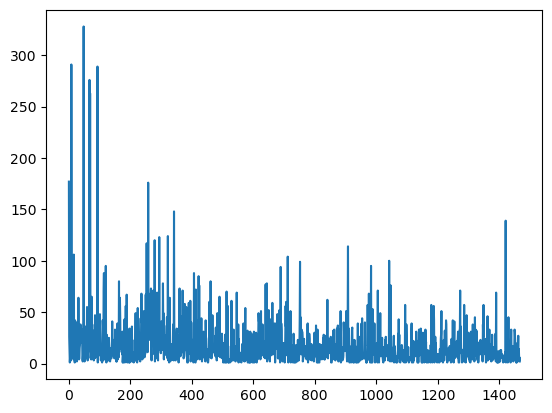

In [272]:
merge4.no_of_transactions.plot()

In [273]:
merge4.recency=merge4.recency.astype("int")

<Axes: >

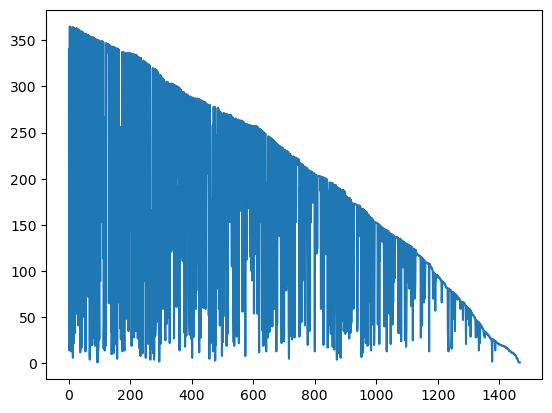

In [274]:
merge4.recency.plot()

In [275]:
from numpy import where as IF

In [276]:
merge4["rfm_segmentation"]=IF((merge4.no_of_transactions<100)&(merge4.recency<50)&(merge4.invoice_value>9000),"premimum",
  IF((merge4.no_of_transactions<100)&(merge4.no_of_transactions>40)&(merge4.recency<150)&(merge4.recency>50)&(merge4.invoice_value<9000)&(merge4.invoice_value>6000)
    ,"gold",IF((merge4.no_of_transactions>40) |((merge4.recency<250)&(merge4.recency>150))|((merge4.invoice_value>3000)&(merge4.invoice_value<6000)),"silver","standard")))
   
   
   

In [277]:
merge4

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,values_based_segment,recency,rfm_segmentation
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,0,0,1,1,1,1,1,premium,340,silver
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,0,1,0,1,0,1,1,silver,14,silver
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,0,0,0,1,1,1,0,silver,152,silver
3,F,California,30,1,2019-01-01,2019-01-01,7.96320,13748,0,0,...,0,0,0,0,0,0,0,standard,365,standard
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,0,0,1,0,0,0,standard,124,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,2019-12-31,2019-12-30,546.93384,14438,1,0,...,0,0,0,1,0,1,0,standard,1,standard
1464,F,Chicago,48,14,2019-12-31,2019-12-31,3286.15547,12956,0,0,...,0,1,0,1,0,1,0,silver,1,silver
1465,M,New Jersey,19,3,2019-12-31,2019-12-31,835.90202,15781,0,0,...,0,0,0,1,0,0,0,standard,1,standard
1466,F,New York,45,6,2019-12-31,2019-12-31,1183.13702,14410,0,0,...,0,1,0,1,0,0,0,standard,1,standard


<Axes: >

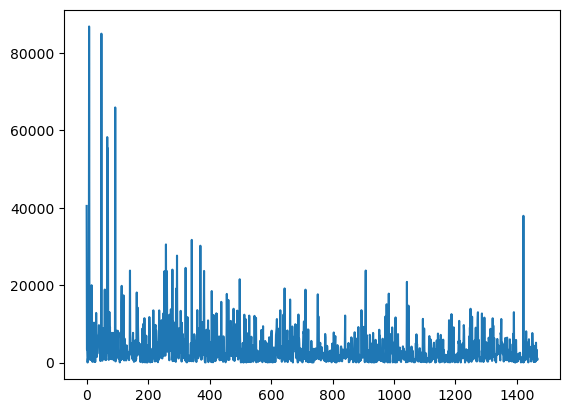

In [278]:
merge4.invoice_value.plot()

In [279]:
merge4["dependent_variable"]=(IF(merge4.invoice_value<3000,0,IF(merge4.invoice_value<6000,1,2)))

In [280]:
merge4

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,values_based_segment,recency,rfm_segmentation,dependent_variable
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,0,1,1,1,1,1,premium,340,silver,2
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,1,0,1,0,1,1,silver,14,silver,1
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,0,0,1,1,1,0,silver,152,silver,1
3,F,California,30,1,2019-01-01,2019-01-01,7.96320,13748,0,0,...,0,0,0,0,0,0,standard,365,standard,0
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,0,1,0,0,0,standard,124,standard,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,F,New York,41,5,2019-12-31,2019-12-30,546.93384,14438,1,0,...,0,0,1,0,1,0,standard,1,standard,0
1464,F,Chicago,48,14,2019-12-31,2019-12-31,3286.15547,12956,0,0,...,1,0,1,0,1,0,silver,1,silver,1
1465,M,New Jersey,19,3,2019-12-31,2019-12-31,835.90202,15781,0,0,...,0,0,1,0,0,0,standard,1,standard,0
1466,F,New York,45,6,2019-12-31,2019-12-31,1183.13702,14410,0,0,...,1,0,1,0,0,0,standard,1,standard,0


In [281]:
class_multi_1=merge4.drop(columns=["rfm_segmentation","values_based_segment","CustomerID","latest_transaction_date", "first_transaction_date","invoice_value"])

In [282]:
class_multi_1.columns

Index(['Gender', 'Location', 'Tenure_Months', 'no_of_transactions',
       'Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles',
       'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear', 'Housewares',
       'Lifestyle', 'MoreBags', 'Nest', 'Nest-Canada', 'Nest-USA',
       'Notebooks&Journals', 'Office', 'Waze', 'recency',
       'dependent_variable'],
      dtype='object')

In [283]:
class_multi_1=pd.concat([class_multi_1,gender_dummy,location_dummy],axis=1)

In [284]:
class_multi_1.drop(columns=["Gender","Location"],inplace=True)

In [285]:
class_multi_1

,Tenure_Months,no_of_transactions,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,...,Notebooks&Journals,Office,Waze,recency,dependent_variable,M,Chicago,New Jersey,New York,Washington DC
0,12,177,0,0,1,1,1,1,1,1,...,1,1,1,340,2,True,True,False,False,False
1,43,26,0,0,1,0,0,0,1,0,...,0,1,1,14,1,True,False,False,False,False
2,33,15,0,0,1,0,1,0,1,0,...,1,1,0,152,1,True,True,False,False,False
3,30,1,0,0,0,0,0,0,0,0,...,0,0,0,365,0,False,False,False,False,False
4,49,6,0,0,1,0,1,0,1,0,...,0,0,0,124,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,41,5,1,0,0,0,0,0,1,0,...,0,1,0,1,0,False,False,False,True,False
1464,48,14,0,0,1,0,0,0,1,0,...,0,1,0,1,1,False,True,False,False,False
1465,19,3,0,0,1,0,0,0,0,0,...,0,0,0,1,0,True,False,True,False,False
1466,45,6,0,0,1,0,0,0,0,0,...,0,0,0,1,0,False,False,False,True,False


In [286]:
!pip install xgboost

In [287]:
from sklearn.feature_selection import RFE, RFECV, SelectKBest, chi2, SelectPercentile, f_classif, mutual_info_classif, f_regression, VarianceThreshold, SelectFromModel, mutual_info_classif, mutual_info_regression, SelectFpr, SelectFdr, SelectFwe



from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz,export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 
from xgboost import XGBClassifier 
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR


In [288]:
x_varible=class_multi_1[class_multi_1.columns.difference(["dependent_variable"])]

In [289]:
y_variable=class_multi_1.dependent_variable

In [290]:
rfe=RFE(DecisionTreeClassifier(),n_features_to_select=10)

In [291]:
rfe=rfe.fit(x_varible,y_variable)

In [292]:
rfe_list=list(x_varible.columns[rfe.get_support()])

In [293]:
k_best_1=SelectKBest(chi2,k=10)

k_best_1.fit(x_varible,y_variable)


SelectKBest(score_func=<function chi2 at 0x000001672A784540>)

In [294]:

k_best_list=list(x_varible.columns[k_best_1.get_support()])

In [295]:
k_best_list

['Bags',
 'Bottles',
 'Headgear',
 'Lifestyle',
 'Nest',
 'Nest-Canada',
 'Notebooks&Journals',
 'Waze',
 'no_of_transactions',
 'recency']

In [296]:
#PCA+ RFE+Select(k-best)

In [297]:
final_x_variables=list(set(selected_variables+k_best_list+rfe_list))

In [298]:
x_varible

,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Chicago,Drinkware,Fun,GiftCards,...,Nest-USA,New Jersey,New York,Notebooks&Journals,Office,Tenure_Months,Washington DC,Waze,no_of_transactions,recency
0,0,0,1,1,1,1,True,1,1,0,...,1,False,False,1,1,12,False,1,177,340
1,0,0,1,0,0,0,False,1,0,0,...,1,False,False,0,1,43,False,1,26,14
2,0,0,1,0,1,0,True,1,0,0,...,1,False,False,1,1,33,False,0,15,152
3,0,0,0,0,0,0,False,0,0,0,...,0,False,False,0,0,30,False,0,1,365
4,0,0,1,0,1,0,False,1,0,0,...,1,False,False,0,0,49,False,0,6,124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,1,0,0,0,0,0,False,1,0,0,...,1,False,True,0,1,41,False,0,5,1
1464,0,0,1,0,0,0,True,1,0,0,...,1,False,False,0,1,48,False,0,14,1
1465,0,0,1,0,0,0,False,0,0,0,...,1,True,False,0,0,19,False,0,3,1
1466,0,0,1,0,0,0,False,0,0,0,...,1,False,True,0,0,45,False,0,6,1


In [299]:
final_x_variables=['Washington_DC',
 'Tenure_Months',
 'Nest',
 'M',
 'Lifestyle',
 'Chicago',
 'recency',
 'Notebooks&Journals',
 'Bags',
 'Android',
 'GiftCards',
 'Bottles',
 'Apparel',
 'Google',
 'Nest-Canada',
 'New_York',
 'New_Jersey',
 'no_of_transactions',
 'Headgear',
 'Waze',
 'Nest-USA']


In [300]:
list15=[]
for i in list(x_varible.columns):
    i=i.replace(" ","_")
    list15.append(i)
    

In [301]:
x_varible.columns=list15

In [302]:
x_varible.columns

Index(['Accessories', 'Android', 'Apparel', 'Backpacks', 'Bags', 'Bottles',
       'Chicago', 'Drinkware', 'Fun', 'GiftCards', 'Google', 'Headgear',
       'Housewares', 'Lifestyle', 'M', 'MoreBags', 'Nest', 'Nest-Canada',
       'Nest-USA', 'New_Jersey', 'New_York', 'Notebooks&Journals', 'Office',
       'Tenure_Months', 'Washington_DC', 'Waze', 'no_of_transactions',
       'recency'],
      dtype='object')

In [303]:
x_variable_final=x_varible[final_x_variables]

In [304]:
#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV

#Module related to calculation of metrics
from sklearn import metrics


we will be using the following for multi-class classification
1. Naive Bayes
2. SVC
3. XGboost

In [305]:
y_variable.value_counts()

dependent_variable
0    920
1    288
2    260
Name: count, dtype: int64

In [306]:
!pip show scikit-learn imbalanced-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: C:\Users\DELL\anaconda3\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: daal4py, imbalanced-learn, mlxtend, pmdarima, scikit-learn-intelex
---
Name: imbalanced-learn
Version: 0.11.0
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: C:\Users\DELL\anaconda3\Lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


In [307]:
from imblearn.over_sampling import SMOTE

In [308]:
#balancing the data
sm = SMOTE()
resampled_X, resampled_y = sm.fit_resample(x_variable_final, y_variable)

In [309]:
resampled_y.value_counts()

dependent_variable
2    920
1    920
0    920
Name: count, dtype: int64

In [310]:
resampled_X.shape

(2760, 21)

In [311]:
train_x,test_x,train_y,test_y=train_test_split(resampled_X,resampled_y,test_size=0.3,random_state=123)

In [312]:
train_x.shape

(1932, 21)

In [313]:
test_x.shape

(828, 21)

In [314]:
train_y.shape

(1932,)

In [315]:
test_y.shape

(828,)

NAIVE BAYES

In [316]:
nb_clf = MultinomialNB()
nb_clf.fit(train_x, train_y)


MultinomialNB()

In [317]:
y_train_predict=nb_clf.predict(train_x)

In [318]:
y_test_predict=nb_clf.predict(test_x)

In [319]:
print(metrics.classification_report(train_y,y_train_predict))

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       641
           1       0.49      0.40      0.44       651
           2       0.61      0.73      0.67       640

    accuracy                           0.61      1932
   macro avg       0.60      0.61      0.60      1932
weighted avg       0.60      0.61      0.60      1932



In [320]:
print(metrics.classification_report(test_y,y_test_predict))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74       279
           1       0.49      0.44      0.46       269
           2       0.64      0.73      0.68       280

    accuracy                           0.64       828
   macro avg       0.63      0.63      0.63       828
weighted avg       0.63      0.64      0.63       828



In [321]:
# 60% and 62% accuracy in train and test data using naive bayes

SVC-support vector classifer

In [322]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'kernel':["linear",'poly','rbf']}
svc_model = GridSearchCV(SVC(random_state=123), param_grid,cv=5)

svc_model=svc_model.fit(train_x, train_y)


In [325]:
svc_model=SVC()

In [326]:
svc_model=svc_model.fit(train_x,train_y)

In [327]:
train_predict_svc=svc_model.predict(train_x)

In [328]:
test_predict_svc=svc_model.predict(test_x)

In [329]:
print(metrics.classification_report(train_y,train_predict_svc))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       641
           1       0.77      0.87      0.82       651
           2       0.93      0.85      0.89       640

    accuracy                           0.87      1932
   macro avg       0.87      0.87      0.87      1932
weighted avg       0.87      0.87      0.87      1932



In [330]:
print(metrics.classification_report(test_y,test_predict_svc))

              precision    recall  f1-score   support

           0       0.93      0.90      0.92       279
           1       0.77      0.88      0.82       269
           2       0.94      0.84      0.89       280

    accuracy                           0.87       828
   macro avg       0.88      0.87      0.87       828
weighted avg       0.88      0.87      0.88       828



In [331]:
xg_boost_model=XGBClassifier()

In [332]:
xg_boost_model=xg_boost_model.fit(train_x,train_y)

In [333]:
train_predict_xg_boost=xg_boost_model.predict(train_x)

In [334]:
test_predict_xg_boost=xg_boost_model.predict(test_x)

In [335]:
print(metrics.classification_report(train_y,train_predict_xg_boost))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       641
           1       1.00      1.00      1.00       651
           2       1.00      1.00      1.00       640

    accuracy                           1.00      1932
   macro avg       1.00      1.00      1.00      1932
weighted avg       1.00      1.00      1.00      1932



In [336]:
print(metrics.classification_report(test_y,test_predict_xg_boost))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       279
           1       0.88      0.91      0.89       269
           2       0.96      0.93      0.94       280

    accuracy                           0.93       828
   macro avg       0.93      0.93      0.93       828
weighted avg       0.93      0.93      0.93       828



6. Predicting Next Purchase Day(How soon each customer can visit the store (0-30 days, 30-60 
days, 60-90 days, 90+ days)

-- For this, we need create dependent variable at customer level (average days per one 
transaction for only repeat customers and divide into groups 0-30 days, 30-60 days, 
60-90 days and 90+ days) then build classification model to predict next purchase of 
given customer.

In [337]:
merge4.CustomerID

0       17850
1       13047
2       12583
3       13748
4       15100
        ...  
1463    14438
1464    12956
1465    15781
1466    14410
1467    14600
Name: CustomerID, Length: 1468, dtype: int64

In [338]:
merge4["days_between"]=((merge4.latest_transaction_date-merge4.first_transaction_date).astype("str").str.split(" ",expand=True)).iloc[:,:1]

In [339]:
req4=merge4[merge4.no_of_transactions>1]

In [340]:
req4.days_between=req4.days_between.astype("int")

C:\Users\DELL\AppData\Local\Temp\ipykernel_18116\3026801503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req4.days_between=req4.days_between.astype("int")


In [341]:
req5=req4[req4.days_between>0]

In [342]:
req5 # we will build classification model to predict next purchase on this dataset only

,Gender,Location,Tenure_Months,no_of_transactions,latest_transaction_date,first_transaction_date,invoice_value,CustomerID,Accessories,Android,...,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,values_based_segment,recency,rfm_segmentation,dependent_variable,days_between
0,M,Chicago,12,177,2019-01-26,2019-01-01,40489.88124,17850,0,0,...,1,1,1,1,1,premium,340,silver,2,25
1,M,California,43,26,2019-12-18,2019-01-01,3348.77498,13047,0,0,...,0,1,0,1,1,silver,14,silver,1,351
2,M,Chicago,33,15,2019-08-02,2019-01-01,3320.84496,12583,0,0,...,0,1,1,1,0,silver,152,silver,1,213
4,M,California,49,6,2019-08-30,2019-01-01,967.73992,15100,0,0,...,0,1,0,0,0,standard,124,standard,0,241
5,M,California,32,13,2019-10-14,2019-01-01,1205.98392,15291,0,0,...,0,1,1,1,1,standard,79,standard,0,286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,F,New York,50,3,2019-12-24,2019-12-23,851.51750,16109,0,0,...,0,1,0,0,0,standard,8,standard,0,1
1456,F,Chicago,17,15,2019-12-26,2019-12-25,2604.54464,15090,0,0,...,0,1,0,0,0,standard,6,standard,0,1
1458,M,Chicago,30,14,2019-12-27,2019-12-26,3255.32260,13911,0,0,...,0,1,0,1,0,silver,5,silver,1,1
1461,M,Chicago,35,16,2019-12-29,2019-12-28,2902.40204,13584,0,0,...,1,1,0,0,0,standard,3,standard,0,1


In [343]:
req5["next_purchase_day"]=req5.days_between/req5.no_of_transactions

C:\Users\DELL\AppData\Local\Temp\ipykernel_18116\4052433091.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req5["next_purchase_day"]=req5.days_between/req5.no_of_transactions


In [344]:
from numpy import where as IF

In [345]:
req5["depenedent_variable"]=IF(req5.next_purchase_day<30,0,IF(req5.next_purchase_day<61,1,2))

C:\Users\DELL\AppData\Local\Temp\ipykernel_18116\923137911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req5["depenedent_variable"]=IF(req5.next_purchase_day<30,0,IF(req5.next_purchase_day<61,1,2))


In [346]:
req5.drop(columns=['latest_transaction_date', 'first_transaction_date','dependent_variable', 'days_between', 'next_purchase_day','CustomerID','values_based_segment','rfm_segmentation'],inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_18116\1317546620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req5.drop(columns=['latest_transaction_date', 'first_transaction_date','dependent_variable', 'days_between', 'next_purchase_day','CustomerID','values_based_segment','rfm_segmentation'],inplace=True)


In [347]:
req5

,Gender,Location,Tenure_Months,no_of_transactions,invoice_value,Accessories,Android,Apparel,Backpacks,Bags,...,Lifestyle,MoreBags,Nest,Nest-Canada,Nest-USA,Notebooks&Journals,Office,Waze,recency,depenedent_variable
0,M,Chicago,12,177,40489.88124,0,0,1,1,1,...,1,0,0,1,1,1,1,1,340,0
1,M,California,43,26,3348.77498,0,0,1,0,0,...,1,0,1,0,1,0,1,1,14,0
2,M,Chicago,33,15,3320.84496,0,0,1,0,1,...,1,0,0,0,1,1,1,0,152,0
4,M,California,49,6,967.73992,0,0,1,0,1,...,0,0,0,0,1,0,0,0,124,1
5,M,California,32,13,1205.98392,0,0,1,0,0,...,1,0,0,0,1,1,1,1,79,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,F,New York,50,3,851.51750,0,0,0,0,0,...,0,0,1,0,1,0,0,0,8,0
1456,F,Chicago,17,15,2604.54464,0,0,1,0,1,...,0,0,1,0,1,0,0,0,6,0
1458,M,Chicago,30,14,3255.32260,0,0,1,0,1,...,0,0,1,0,1,0,1,0,5,0
1461,M,Chicago,35,16,2902.40204,0,0,1,0,0,...,1,0,1,1,1,0,0,0,3,0


In [348]:
gender_dummy_1=pd.get_dummies(req5.Gender,drop_first=True)

In [349]:
location_dummy_1=pd.get_dummies(req5.Location,drop_first=True)

In [350]:
req5.drop(columns=["Gender","Location"],inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_18116\686416725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  req5.drop(columns=["Gender","Location"],inplace=True)


In [351]:
final_dataset=pd.concat([req5,gender_dummy_1,location_dummy_1],axis=1)

In [352]:
y_final_variable=final_dataset.depenedent_variable

In [353]:
x_final_variable=final_dataset[list(final_dataset.columns.difference(["depenedent_variable"]))]

In [354]:
x_final_variable

,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Chicago,Drinkware,Fun,GiftCards,...,New Jersey,New York,Notebooks&Journals,Office,Tenure_Months,Washington DC,Waze,invoice_value,no_of_transactions,recency
0,0,0,1,1,1,1,True,1,1,0,...,False,False,1,1,12,False,1,40489.88124,177,340
1,0,0,1,0,0,0,False,1,0,0,...,False,False,0,1,43,False,1,3348.77498,26,14
2,0,0,1,0,1,0,True,1,0,0,...,False,False,1,1,33,False,0,3320.84496,15,152
4,0,0,1,0,1,0,False,1,0,0,...,False,False,0,0,49,False,0,967.73992,6,124
5,0,0,1,0,0,0,False,1,0,0,...,False,False,1,1,32,False,1,1205.98392,13,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,0,0,False,0,0,0,...,False,True,0,0,50,False,0,851.51750,3,8
1456,0,0,1,0,1,0,True,0,0,0,...,False,False,0,0,17,False,0,2604.54464,15,6
1458,0,0,1,0,1,0,True,1,0,0,...,False,False,0,1,30,False,0,3255.32260,14,5
1461,0,0,1,0,0,0,True,1,0,0,...,False,False,0,0,35,False,0,2902.40204,16,3


In [355]:
from imblearn.over_sampling import SMOTE

In [356]:
# need to resample data

In [357]:
y_final_variable=y_final_variable.rename("y_final_variable")

In [358]:
y_final_variable

0       0
1       0
2       0
4       1
5       0
       ..
1454    0
1456    0
1458    0
1461    0
1463    0
Name: y_final_variable, Length: 734, dtype: int32

In [359]:
x_final_variable

,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Chicago,Drinkware,Fun,GiftCards,...,New Jersey,New York,Notebooks&Journals,Office,Tenure_Months,Washington DC,Waze,invoice_value,no_of_transactions,recency
0,0,0,1,1,1,1,True,1,1,0,...,False,False,1,1,12,False,1,40489.88124,177,340
1,0,0,1,0,0,0,False,1,0,0,...,False,False,0,1,43,False,1,3348.77498,26,14
2,0,0,1,0,1,0,True,1,0,0,...,False,False,1,1,33,False,0,3320.84496,15,152
4,0,0,1,0,1,0,False,1,0,0,...,False,False,0,0,49,False,0,967.73992,6,124
5,0,0,1,0,0,0,False,1,0,0,...,False,False,1,1,32,False,1,1205.98392,13,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0,0,0,0,0,0,False,0,0,0,...,False,True,0,0,50,False,0,851.51750,3,8
1456,0,0,1,0,1,0,True,0,0,0,...,False,False,0,0,17,False,0,2604.54464,15,6
1458,0,0,1,0,1,0,True,1,0,0,...,False,False,0,1,30,False,0,3255.32260,14,5
1461,0,0,1,0,0,0,True,1,0,0,...,False,False,0,0,35,False,0,2902.40204,16,3


In [360]:
list16=[]
for i in list(x_final_variable.columns):
    i=i.replace(" ","_")
    list16.append(i)

In [361]:
x_final_variable.columns=list16

In [362]:
rfe_1=RFE(DecisionTreeClassifier(),n_features_to_select=10)

rfe_1=rfe_1.fit(x_final_variable,y_final_variable)

rfe_list_1=list(x_final_variable.columns[rfe_1.get_support()])

k_best_2=SelectKBest(chi2,k=10)

k_best_2.fit(x_final_variable,y_final_variable)



k_best_list_1=list(x_final_variable.columns[k_best_2.get_support()])



In [363]:
k_best_list_1

['Bags',
 'Headgear',
 'Lifestyle',
 'Nest',
 'Nest-Canada',
 'Tenure_Months',
 'Waze',
 'invoice_value',
 'no_of_transactions',
 'recency']

In [364]:
rfe_list_1

['Accessories',
 'Bags',
 'Nest-Canada',
 'Office',
 'Tenure_Months',
 'Washington_DC',
 'Waze',
 'invoice_value',
 'no_of_transactions',
 'recency']

In [365]:
z21=list(set(selected_variables+k_best_list_1+rfe_list_1))

In [366]:
z21=['Headgear',
 'Google',
 'Accessories',
 'Waze',
 'New_York',
 'Nest',
 'Bags',
 'recency',
 'M',
 'Tenure_Months',
 'Washington_DC',
 'GiftCards',
 'no_of_transactions',
 'Nest-USA',
 'Chicago',
 'invoice_value',
 'Nest-Canada',
 'New_Jersey',
 'Android',
 'Apparel',
 'Lifestyle',
 'Office']

In [367]:
x_final_variable=x_final_variable[z21]

In [368]:
sm1=SMOTE(random_state=123)

sm1.fit(x_final_variable,y_final_variable)

SMOTE(random_state=123)

In [369]:
resampled_x_1,resample_y_1=sm1.fit_resample(x_final_variable,y_final_variable)

In [370]:
resample_y_1.value_counts()

y_final_variable
0    700
1    700
2    700
Name: count, dtype: int64

In [371]:
resampled_x_1.shape

(2100, 22)

We will use the 3 methods for multi-class classification

1. Kmeans as the number of records is less

2. XGBoost

3. SVC

In [372]:
train_x,test_x,train_y,test_y=train_test_split(resampled_x_1,resample_y_1,test_size=0.2,random_state=123)

In [373]:
train_x.shape

(1680, 22)

In [374]:
test_x.shape

(420, 22)

In [375]:
train_y.shape

(1680,)

In [376]:
test_y.shape

(420,)

In [377]:
from sklearn.preprocessing import StandardScaler

In [378]:
sc_1=StandardScaler().fit(train_x)

In [379]:
train_x_std=pd.DataFrame(sc_1.transform(train_x),columns=train_x.columns)

In [380]:
test_x_std=pd.DataFrame(sc_1.transform(test_x),columns=test_x.columns)

In [383]:
#Using GridsearchCV with standrardized data
param_grid = {'n_neighbors':[5,6,7,8,9,10],
              'weights': ['uniform', 'distance']}
model_Kmean = GridSearchCV(KNeighborsClassifier(), param_grid = param_grid, cv=5, scoring = 'accuracy')


In [384]:
model_kmean = model_Kmean.fit(train_x_std, train_y)

In [385]:
model_kmean.best_params_

{'n_neighbors': 6, 'weights': 'distance'}

In [386]:
model_Kmeans_1=KNeighborsClassifier(n_neighbors=6,weights="distance")

In [389]:
model_Kmeans_1=model_Kmeans_1.fit(train_x_std,train_y)

In [390]:
pred_train_kmeans=model_Kmeans_1.predict(train_x_std)

In [391]:
pred_test_kmeans=model_Kmeans_1.predict(test_x_std)

In [392]:
print(metrics.classification_report(train_y,pred_train_kmeans))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       551
           2       1.00      1.00      1.00       570

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680



In [393]:
print(metrics.classification_report(test_y,pred_test_kmeans))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93       141
           1       0.91      0.97      0.94       149
           2       0.97      1.00      0.98       130

    accuracy                           0.95       420
   macro avg       0.96      0.95      0.95       420
weighted avg       0.95      0.95      0.95       420



In [394]:
# getting 100% accuracy in train and 93% accuracy in test data

In [395]:
# without any tuning paramter

In [396]:
xgb1=XGBClassifier()

In [397]:
xgb1=xgb1.fit(train_x,train_y)

In [398]:
train_predict_xgb=xgb1.predict(train_x)

In [399]:
test_predict_xgb=xgb1.predict(test_x)

In [400]:
print(metrics.classification_report(train_y,train_predict_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       559
           1       1.00      1.00      1.00       551
           2       1.00      1.00      1.00       570

    accuracy                           1.00      1680
   macro avg       1.00      1.00      1.00      1680
weighted avg       1.00      1.00      1.00      1680



In [401]:
print(metrics.classification_report(test_y,test_predict_xgb))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       141
           1       0.95      1.00      0.97       149
           2       0.99      1.00      1.00       130

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



SVC(support vector classifer)

In [403]:
sv1=SVC()

In [404]:
sv1=sv1.fit(train_x,train_y)

In [405]:
pred_train_svc=sv1.predict(train_x)

In [406]:
pred_test_svc=sv1.predict(test_x)

In [407]:
print(metrics.classification_report(train_y,pred_train_svc))

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       559
           1       0.57      0.50      0.54       551
           2       0.62      0.78      0.69       570

    accuracy                           0.70      1680
   macro avg       0.72      0.70      0.70      1680
weighted avg       0.72      0.70      0.70      1680



In [408]:
print(metrics.classification_report(test_y,pred_test_svc))

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       141
           1       0.52      0.36      0.43       149
           2       0.53      0.77      0.63       130

    accuracy                           0.64       420
   macro avg       0.65      0.65      0.64       420
weighted avg       0.65      0.64      0.63       420



In [410]:
#svc_1=GridSearchCV(SVC(random_state=123),param_grid_1,cv=5,scoring="accuracy")

In [411]:
#svc_1=svc_1.fit(train_x,train_y)

7. Perform cohort analysis by defining below cohorts

a Customers who started in each month and understand their behaviour

b Which Month cohort has maximum retention?

In [412]:
req2

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,product_categgory_sales_table,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,...,Discount_pct,primary_key,Product_Category,GST,updated_dis_per,invoice_value,new_old_cust,new_repeat_week,new_repeat_day,GST_AMOUNT
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,10.0,JanNest-USA,Nest-USA,0.10,10.0,158.67290,new,new,new,13.83390
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,...,10.0,JanNest-USA,Nest-USA,0.10,10.0,158.67290,new,new,new,13.83390
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,...,10.0,JanOffice,Office,0.10,10.0,8.52950,new,new,new,0.18450
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,...,10.0,JanApparel,Apparel,0.18,0.0,109.92700,new,new,new,14.19930
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,...,10.0,JanBags,Bags,0.18,10.0,24.02300,new,new,new,2.67300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,...,30.0,DecNest-USA,Nest-USA,0.10,0.0,139.93000,new,new,repeat,8.49100
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,...,30.0,DecApparel,Apparel,0.18,30.0,46.90792,new,new,repeat,6.16392
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,...,30.0,DecNest-USA,Nest-USA,0.10,30.0,123.44760,new,new,repeat,10.63160
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,...,30.0,DecNest-USA,Nest-USA,0.10,0.0,449.36000,new,new,repeat,28.18200


In [413]:
def function_common(df):
    m1=df.transaction_month
    if m1==12:
        pass
    else:
        y2=t_month_cust_dict[m1+1]
        if df.CustomerID in y2:
            return True
    return False


In [414]:
req2["month_cohort"]=req2.apply(function_common,axis=1)

In [415]:
req2.month_cohort.value_counts()

month_cohort
False    44365
True      8559
Name: count, dtype: int64

In [416]:
req2["month_cohort"]=IF(req2.month_cohort==False,"new","repeat")

In [417]:
req2.month_cohort.value_counts()

month_cohort
new       44365
repeat     8559
Name: count, dtype: int64

In [418]:
q_7=req2.groupby(["month_cohort","transaction_month"]).agg({"CustomerID":"nunique"}).reset_index()

In [419]:
req2.columns

Index(['CustomerID', 'Transaction_ID', 'Transaction_Date', 'Product_SKU',
       'Product_Description', 'product_categgory_sales_table', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status', 'transaction_month',
       'transaction_day', 'week_no', 'abbrevaited_month_name', 'key', 'Month',
       'Coupon_Code', 'Discount_pct', 'primary_key', 'Product_Category', 'GST',
       'updated_dis_per', 'invoice_value', 'new_old_cust', 'new_repeat_week',
       'new_repeat_day', 'GST_AMOUNT', 'month_cohort'],
      dtype='object')

In [420]:
part_a=q_7[q_7.month_cohort=="new"]

In [421]:
part_b=q_7[q_7.month_cohort=="repeat"]

In [422]:
part_a=part_a.iloc[:-1,:]

In [423]:
part_b=part_b.reset_index()

In [424]:
q_7_final=pd.concat([part_a,part_b],axis=1)

In [425]:
q_7_final.columns=["a","month","not_retained","b","c","d","retained"]

In [426]:
q_7_final.drop(columns=["a","b","c","d"],inplace=True)

In [427]:
q_7_final["total_cust"]=q_7_final.not_retained+q_7_final.retained

In [428]:
q_7_final["percenatge_retaned"]=(q_7_final.retained/q_7_final.total_cust)*100

In [429]:
q_7_final

,month,not_retained,retained,total_cust,percenatge_retaned
0,1,202,13,215,6.046512
1,2,98,11,109,10.091743
2,3,184,24,208,11.538462
3,4,199,25,224,11.160714
4,5,163,37,200,18.500000
5,6,201,58,259,22.393822
6,7,171,65,236,27.542373
7,8,256,44,300,14.666667
8,9,164,29,193,15.025907
9,10,179,31,210,14.761905


<Axes: xlabel='month', ylabel='percenatge_retaned'>

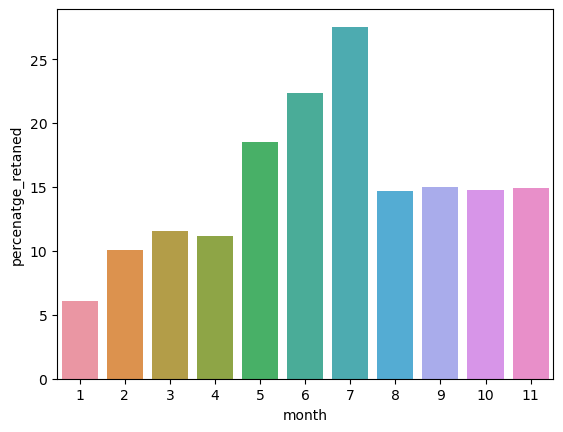

In [430]:
sns.barplot(x="month",y="percenatge_retaned",data=q_7_final)

In [431]:
q_7_final.columns

Index(['month', 'not_retained', 'retained', 'total_cust',
       'percenatge_retaned'],
      dtype='object')

5. Cross-Selling (Which products are selling together)

-You can perform exploratory analysis & market basket analysis to understand which 
of items can be bundled together

In [435]:
# req2.groupby([""])

In [436]:
req2.Product_Description

0        Nest Learning Thermostat 3rd Gen-USA - Stainle...
1        Nest Learning Thermostat 3rd Gen-USA - Stainle...
2                    Google Laptop and Cell Phone Stickers
3        Google Men's 100% Cotton Short Sleeve Hero Tee...
4                          Google Canvas Tote Natural/Navy
                               ...                        
52919                Nest Cam Indoor Security Camera - USA
52920                              Google Zip Hoodie Black
52921         Nest Learning Thermostat 3rd Gen-USA - White
52922        Nest Protect Smoke + CO White Wired Alarm-USA
52923      Nest Protect Smoke + CO White Battery Alarm-USA
Name: Product_Description, Length: 52924, dtype: object

In [437]:
from mlxtend.frequent_patterns import apriori

In [438]:
from mlxtend.frequent_patterns import association_rules

In [439]:
req2.Product_Description=req2.Product_Description.str.strip()

In [ ]:
req2.Transaction_ID

In [440]:
q5=req2.groupby(["Transaction_ID","Product_Description"]).agg({"Product_Description":"count"}).unstack()

In [441]:
q5=q5.fillna(0)

In [442]:
q5

Product_Description  \
Product_Description 1 oz Hand Sanitizer   
Transaction_ID                            
16679                               0.0   
16680                               0.0   
16681                               0.0   
16682                               0.0   
16684                               0.0   
...                                 ...   
48493                               0.0   
48494                               0.0   
48495                               0.0   
48496                               0.0   
48497                               0.0   

                                                             \
Product_Description 20 oz Stainless Steel Insulated Tumbler   
Transaction_ID                                                
16679                                                   0.0   
16680                                                   0.0   
16681                                                   0.0   
16682                                                   0.0   
16684                                                   0.0   
...                                                     ...   
48493                                                   0.0   
48494                                                   0.0   
48495                                                   0.0   
48496                                                   0.0   
48497                                                   0.0   

                                                                       \
Product_Description 22 oz Android Bottle 22 oz YouTube Bottle Infuser   
Transaction_ID                                                          
16679                                0.0                          0.0   
16680                                0.0                          0.0   
16681                                0.0                          0.0   
16682                                0.0                          0.0   
16684                                0.0                          0.0   
...                                  ...                          ...   
48493                                0.0                          0.0   
48494                                0.0                          0.0   
48495                                0.0                          0.0   
48496                                0.0                          0.0   
48497                                0.0                          0.0   

                                                   \
Product_Description 23 oz Wide Mouth Sport Bottle   
Transaction_ID                                      
16679                                         0.0   
16680                                         0.0   
16681                                         0.0   
16682                                         0.0   
16684                                         0.0   
...                                           ...   
48493                                         0.0   
48494                                         0.0   
48495                                         0.0   
48496                                         0.0   
48497                                         0.0   

                                                                               \
Product_Description 24 oz YouTube Sergeant Stripe Bottle 25L Classic Rucksack   
Transaction_ID                                                                  
16679                                                0.0                  0.0   
16680                                                0.0                  0.0   
16681                                                0.0                  0.0   
16682                                                0.0                  0.0   
16684                                                0.0                  0.0   
...                                                  ...                  ...   
48493                                  

In [443]:
def market_basket(x):
    if x>0:
        return 1
    else:
        return 0
        

In [444]:
q5=q5.applymap(market_basket)

In [445]:
q5

Product_Description  \
Product_Description 1 oz Hand Sanitizer   
Transaction_ID                            
16679                                 0   
16680                                 0   
16681                                 0   
16682                                 0   
16684                                 0   
...                                 ...   
48493                                 0   
48494                                 0   
48495                                 0   
48496                                 0   
48497                                 0   

                                                             \
Product_Description 20 oz Stainless Steel Insulated Tumbler   
Transaction_ID                                                
16679                                                     0   
16680                                                     0   
16681                                                     0   
16682                                                     0   
16684                                                     0   
...                                                     ...   
48493                                                     0   
48494                                                     0   
48495                                                     0   
48496                                                     0   
48497                                                     0   

                                                                       \
Product_Description 22 oz Android Bottle 22 oz YouTube Bottle Infuser   
Transaction_ID                                                          
16679                                  0                            0   
16680                                  0                            0   
16681                                  0                            0   
16682                                  0                            0   
16684                                  0                            0   
...                                  ...                          ...   
48493                                  0                            0   
48494                                  0                            0   
48495                                  0                            0   
48496                                  0                            0   
48497                                  0                            0   

                                                   \
Product_Description 23 oz Wide Mouth Sport Bottle   
Transaction_ID                                      
16679                                           0   
16680                                           0   
16681                                           0   
16682                                           0   
16684                                           0   
...                                           ...   
48493                                           0   
48494                                           0   
48495                                           0   
48496                                           0   
48497                                           0   

                                                                               \
Product_Description 24 oz YouTube Sergeant Stripe Bottle 25L Classic Rucksack   
Transaction_ID                                                                  
16679                                                  0                    0   
16680                                                  0                    0   
16681                                                  0                    0   
16682                                                  0                    0   
16684                                                  0                    0   
...                                                  ...                  ...   
48493                                  

In [446]:
#Model building

In [447]:
apriori?

In [448]:
my_frequent_items=apriori(q5,min_support=0.02,use_colnames=True)

C:\Users\DELL\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [449]:
my_rules=association_rules(my_frequent_items,metric="lift",min_threshold=1)

In [450]:
my_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"((Product_Description, Nest Cam Indoor Securit...","((Product_Description, Nest Cam Outdoor Securi...",0.128886,0.132796,0.027653,0.214551,1.615644,0.010537,1.104087,0.437430
1,"((Product_Description, Nest Cam Outdoor Securi...","((Product_Description, Nest Cam Indoor Securit...",0.132796,0.128886,0.027653,0.208233,1.615644,0.010537,1.100216,0.439403


In [451]:
my_rules.antecedents[0]

frozenset({('Product_Description', 'Nest Cam Indoor Security Camera - USA')})